In [20]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmap
import numpy as np
import pandas as pd
plt.rcParams.update({'font.size': 8})
import pybamm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.scale import FuncScale

In [21]:
# historic energy demand met by LIBs, (2010-2025) + Andy's extrapolated (2025-2030)
    # also has column for % demand met by each cathode at each year 
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

function to calculate mass of each critical mineral by GWh and cathode type: 

In [23]:
def AM_calc(GWh, voltage, type): 
    
    """
    input: desired GWh/y, nominal voltage, type of LIB cathode 
    output: active mass required of Li, Ni, Mn, Co for NMC622, NMC811, NMC532, NMC111, LCO, LFP
    """ 

    cap622 = 0.180 # Ah/g , experimental specific capacity NMC622
    cap811 = 0.200 # Ah/g , experimental specific capacity NMC811
    cap532 = 0.170 # Ah/g , experimental specific capacity NMC532
    cap111 = 0.160 # Ah/g , experimental specific capacity NMC111
    capLFP = 0.120 # Ah/g , experimental specific capacity LiFePO4
    capLCO = 0.140 # Ah/g , experimental specific capacity LiCoO2
    elyte = 0.005863 # wt% Li in 1M LiPF6 in 1:1 EC:DEC

    options = ["NMC622", "NMC811", "NMC532", "NMC111", "LFP", "LCO"]
    if type not in options: 
        print(f'{type} is an unsupported cathode at this time.')

    if type == "NMC622":
        masses_622 = []
        element_622 = [(0.07162+elyte), 0.3634, 0.1134, 0.1216] # percent of each element in NMC622 cell (order: Li, Ni, Mn, Co)
        for e in element_622: 
            AM_mass = ((GWh * 1000) / (voltage * cap622)) * e
            masses_622.append(AM_mass)
        return masses_622
    elif type == "NMC811": 
        masses_811 = []
        element_811 = [(0.07136+elyte), 0.4828, 0.05648, 0.06059] # percent of each element in NMC811
        for e in element_811: 
            AM_mass = ((GWh * 1000) / (voltage * cap811)) * e
            masses_811.append(AM_mass)
        return masses_811
    elif type == "NMC532": 
        masses_532 = []
        element_532 = [(0.07190+elyte), 0.3040, 0.1707, 0.1221]  # percent of each element in NMC532
        for e in element_532: 
            AM_mass = ((GWh * 1000) / (voltage * cap532)) * e
            masses_532.append(AM_mass)
        return masses_532
    elif type == "NMC111": 
        masses_111 = []
        element_111 = [(0.0328+elyte), 0.2775, 0.2598, 0.2787]  # percent of each element in NMC111
        for e in element_111: 
            AM_mass = ((GWh * 1000) / (voltage * cap111)) * e
            masses_111.append(AM_mass)
        return masses_111
    elif type == "LFP": 
        masses_LFP = []
        element_LFP = [(0.044+elyte), 0, 0, 0]  # percent of each element in LiFePO4
        for e in element_LFP: 
            AM_mass = ((GWh * 1000) / (voltage * capLFP)) * e
            masses_LFP.append(AM_mass)
        return masses_LFP
    elif type == "LCO": 
        masses_LCO = []
        element_LCO = [(0.0709+elyte), 0, 0, 0.602]  # percent of each element in NMC111
        for e in element_LCO: 
            AM_mass = ((GWh * 1000) / (voltage * capLCO)) * e
            masses_LCO.append(AM_mass)
        return masses_LCO

plotting historic energy demand met by LIBs:

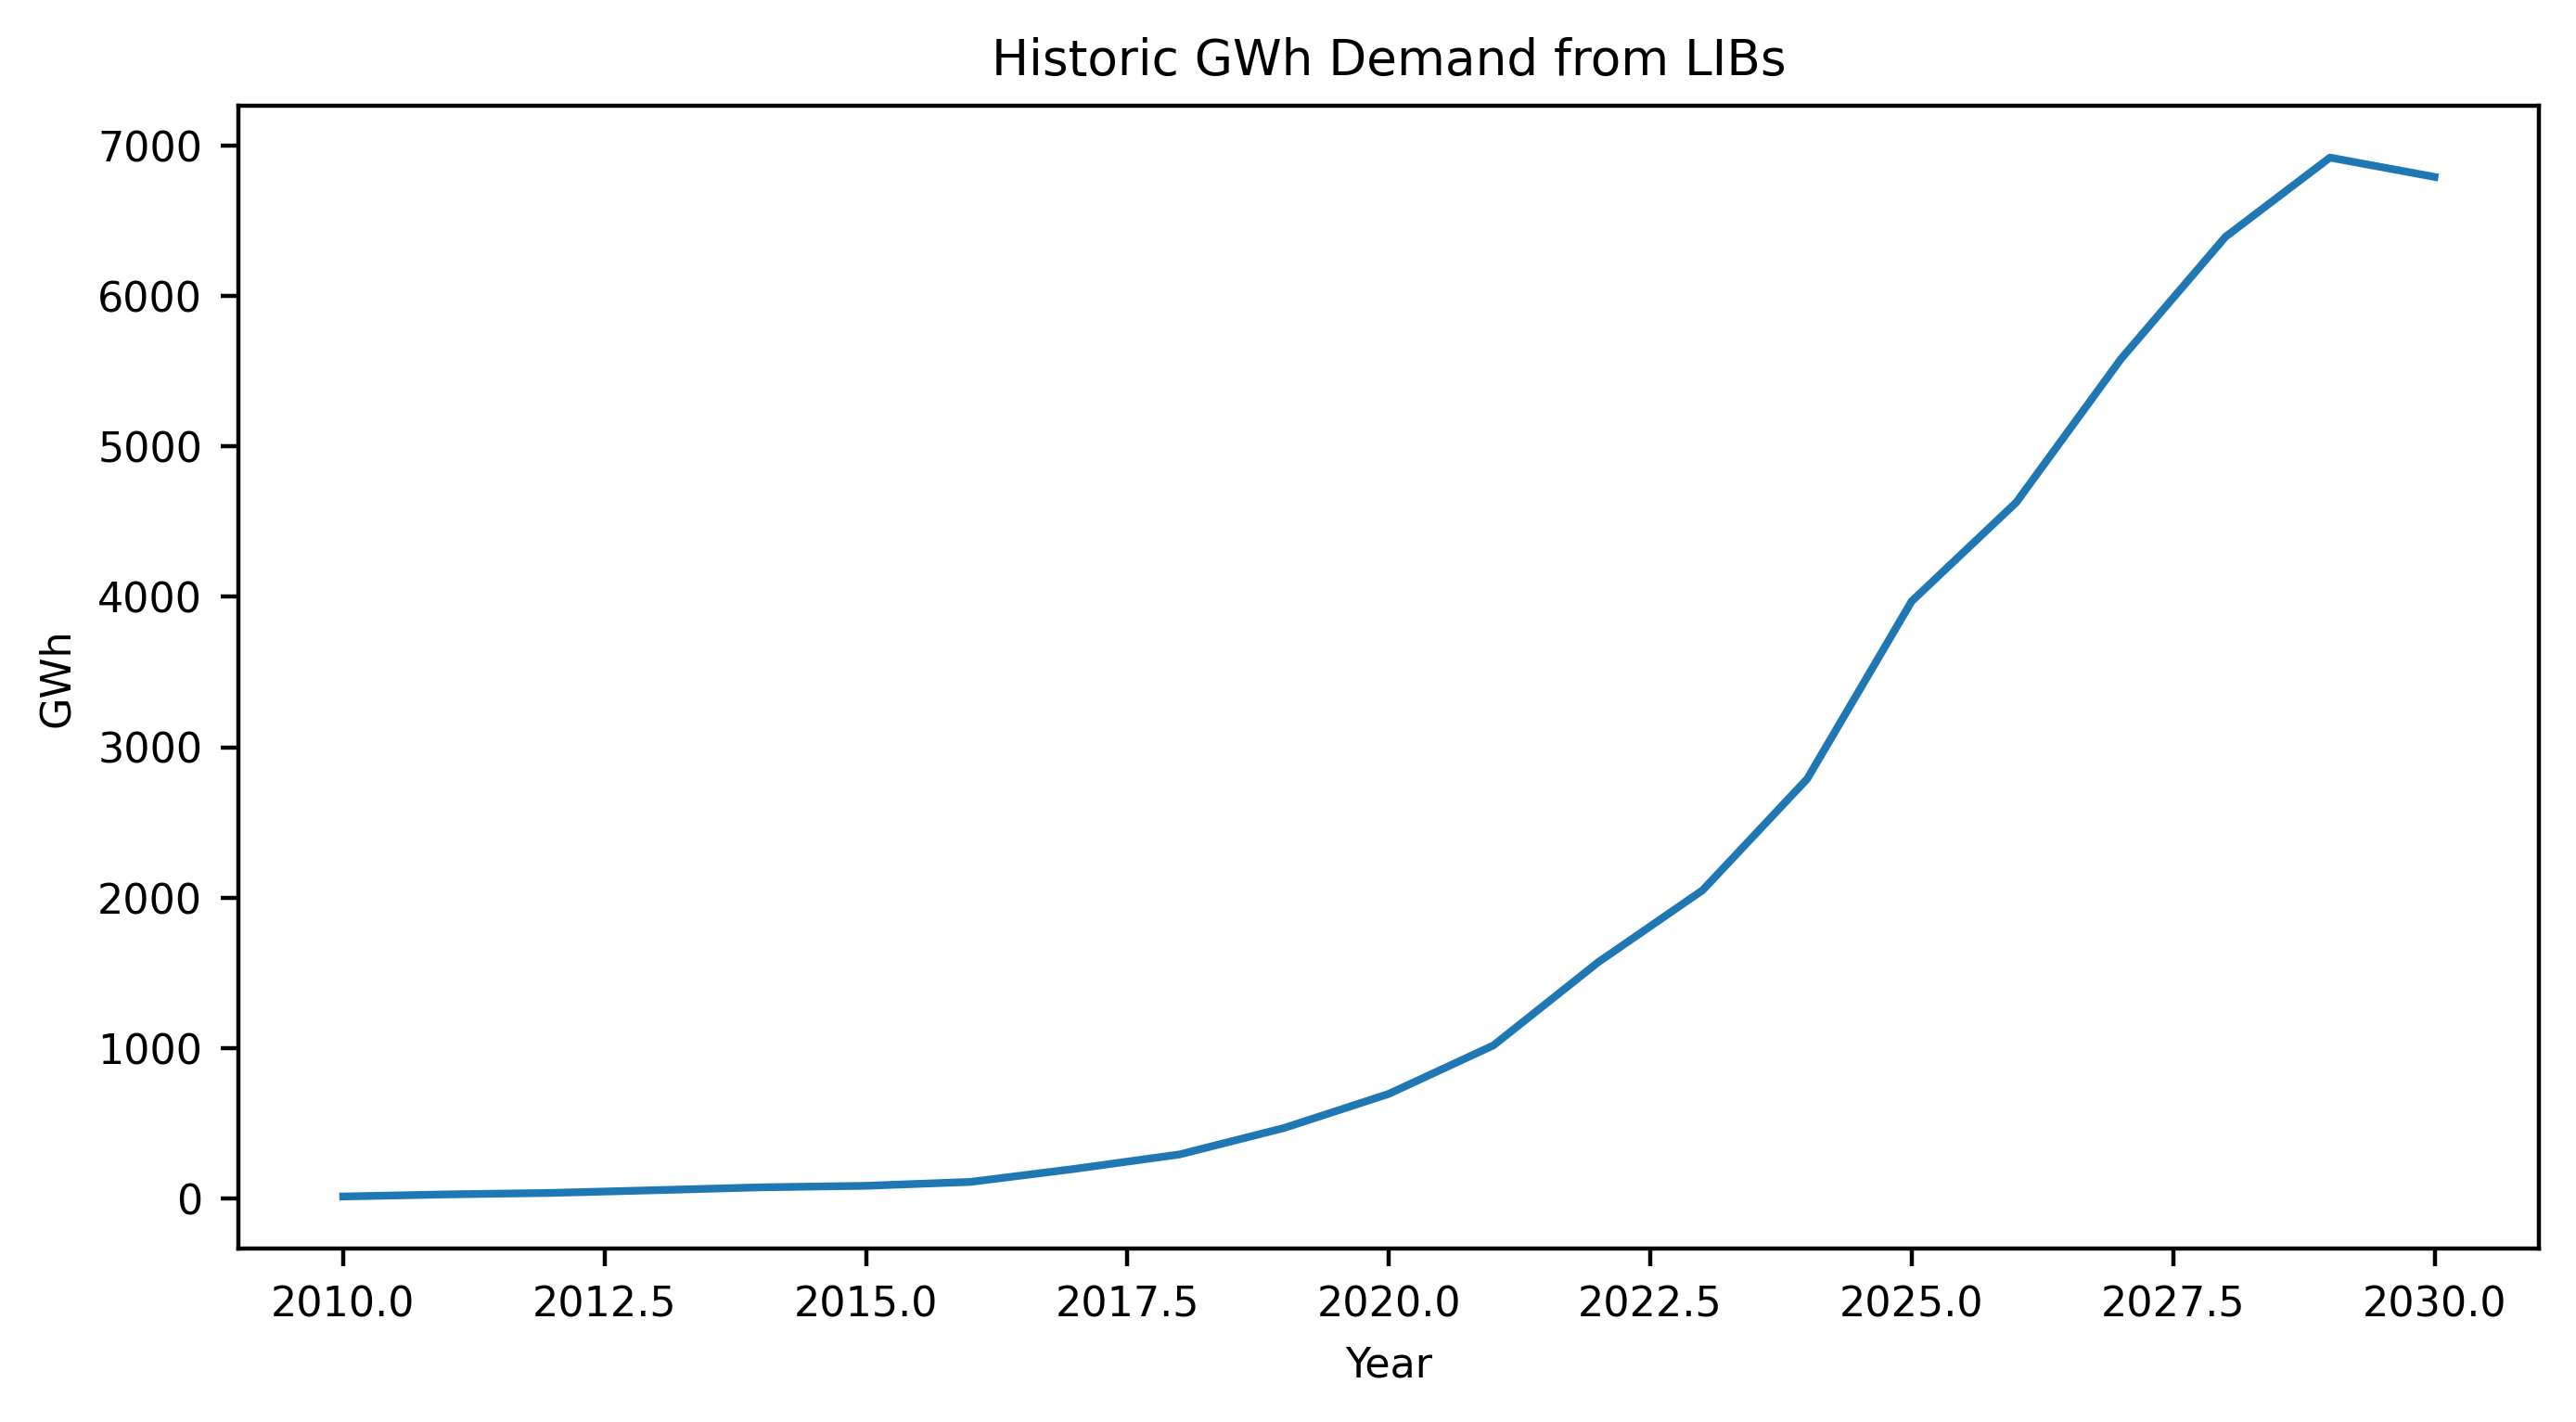

In [24]:
plt.figure(dpi=400,figsize=(8, 4))
plt.plot(df_demand['Year'], df_demand['Capacity'])
plt.xlabel('Year')
plt.ylabel('GWh')
plt.title('Historic GWh Demand from LIBs')
plt.show()

plotting CM masses required to meet historic demand (assume 100% NMC811): 

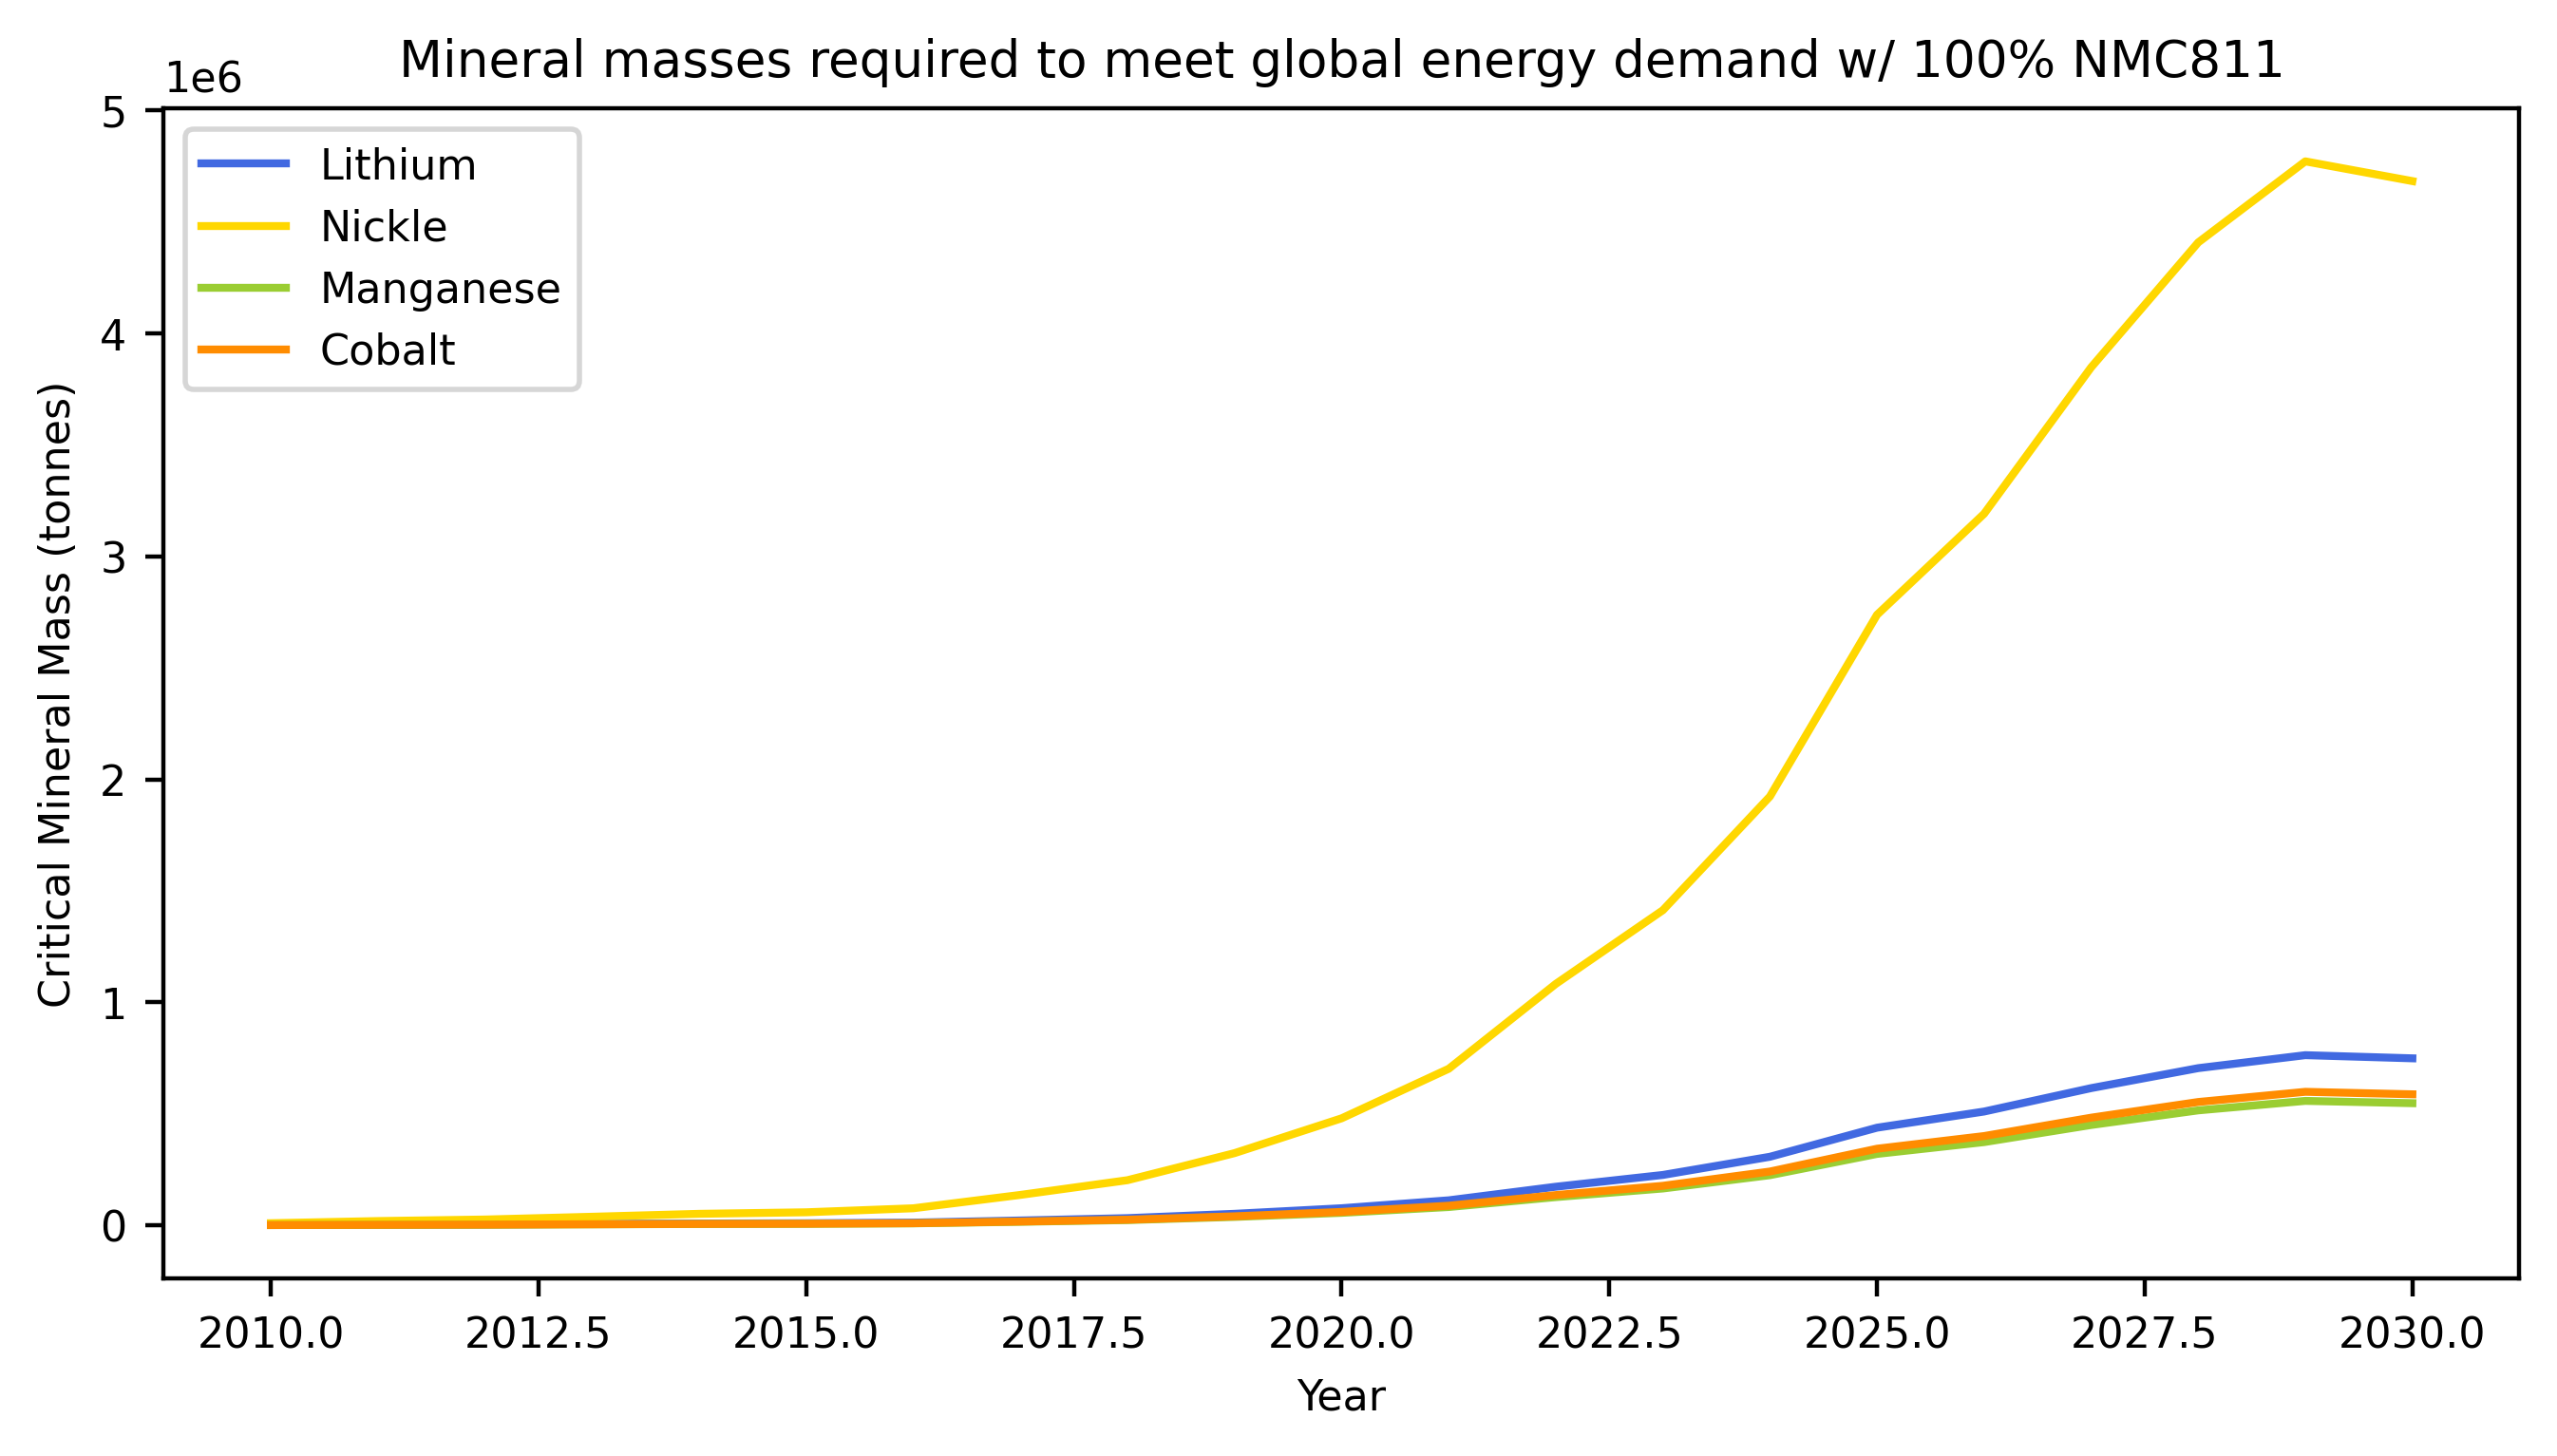

In [25]:
Li_mass = [AM_calc(yr, 3.5, "NMC811")[0] for yr in df_demand['Capacity']]
Ni_mass = [AM_calc(yr, 3.5, "NMC811")[1] for yr in df_demand['Capacity']]
Mn_mass = [AM_calc(yr, 3.5, "NMC811")[2] for yr in df_demand['Capacity']]
Co_mass = [AM_calc(yr, 3.5, "NMC811")[3] for yr in df_demand['Capacity']]

plt.figure(dpi=400,figsize=(8, 4))
plt.plot(df_demand['Year'], Li_mass, label = 'Lithium', color = 'royalblue')
plt.plot(df_demand['Year'], Ni_mass, label = 'Nickle', color = 'gold')
plt.plot(df_demand['Year'], Mn_mass, label = 'Manganese', color = 'yellowgreen')
plt.plot(df_demand['Year'], Co_mass, label = 'Cobalt', color = 'darkorange')
plt.xlabel('Year')
plt.ylabel('Critical Mineral Mass (tonnes)')
plt.legend()
plt.title('Mineral masses required to meet global energy demand w/ 100% NMC811')
plt.show()

plotting CM masses required to meet historic demand (assume 80% LFP, 20% NMC811): 

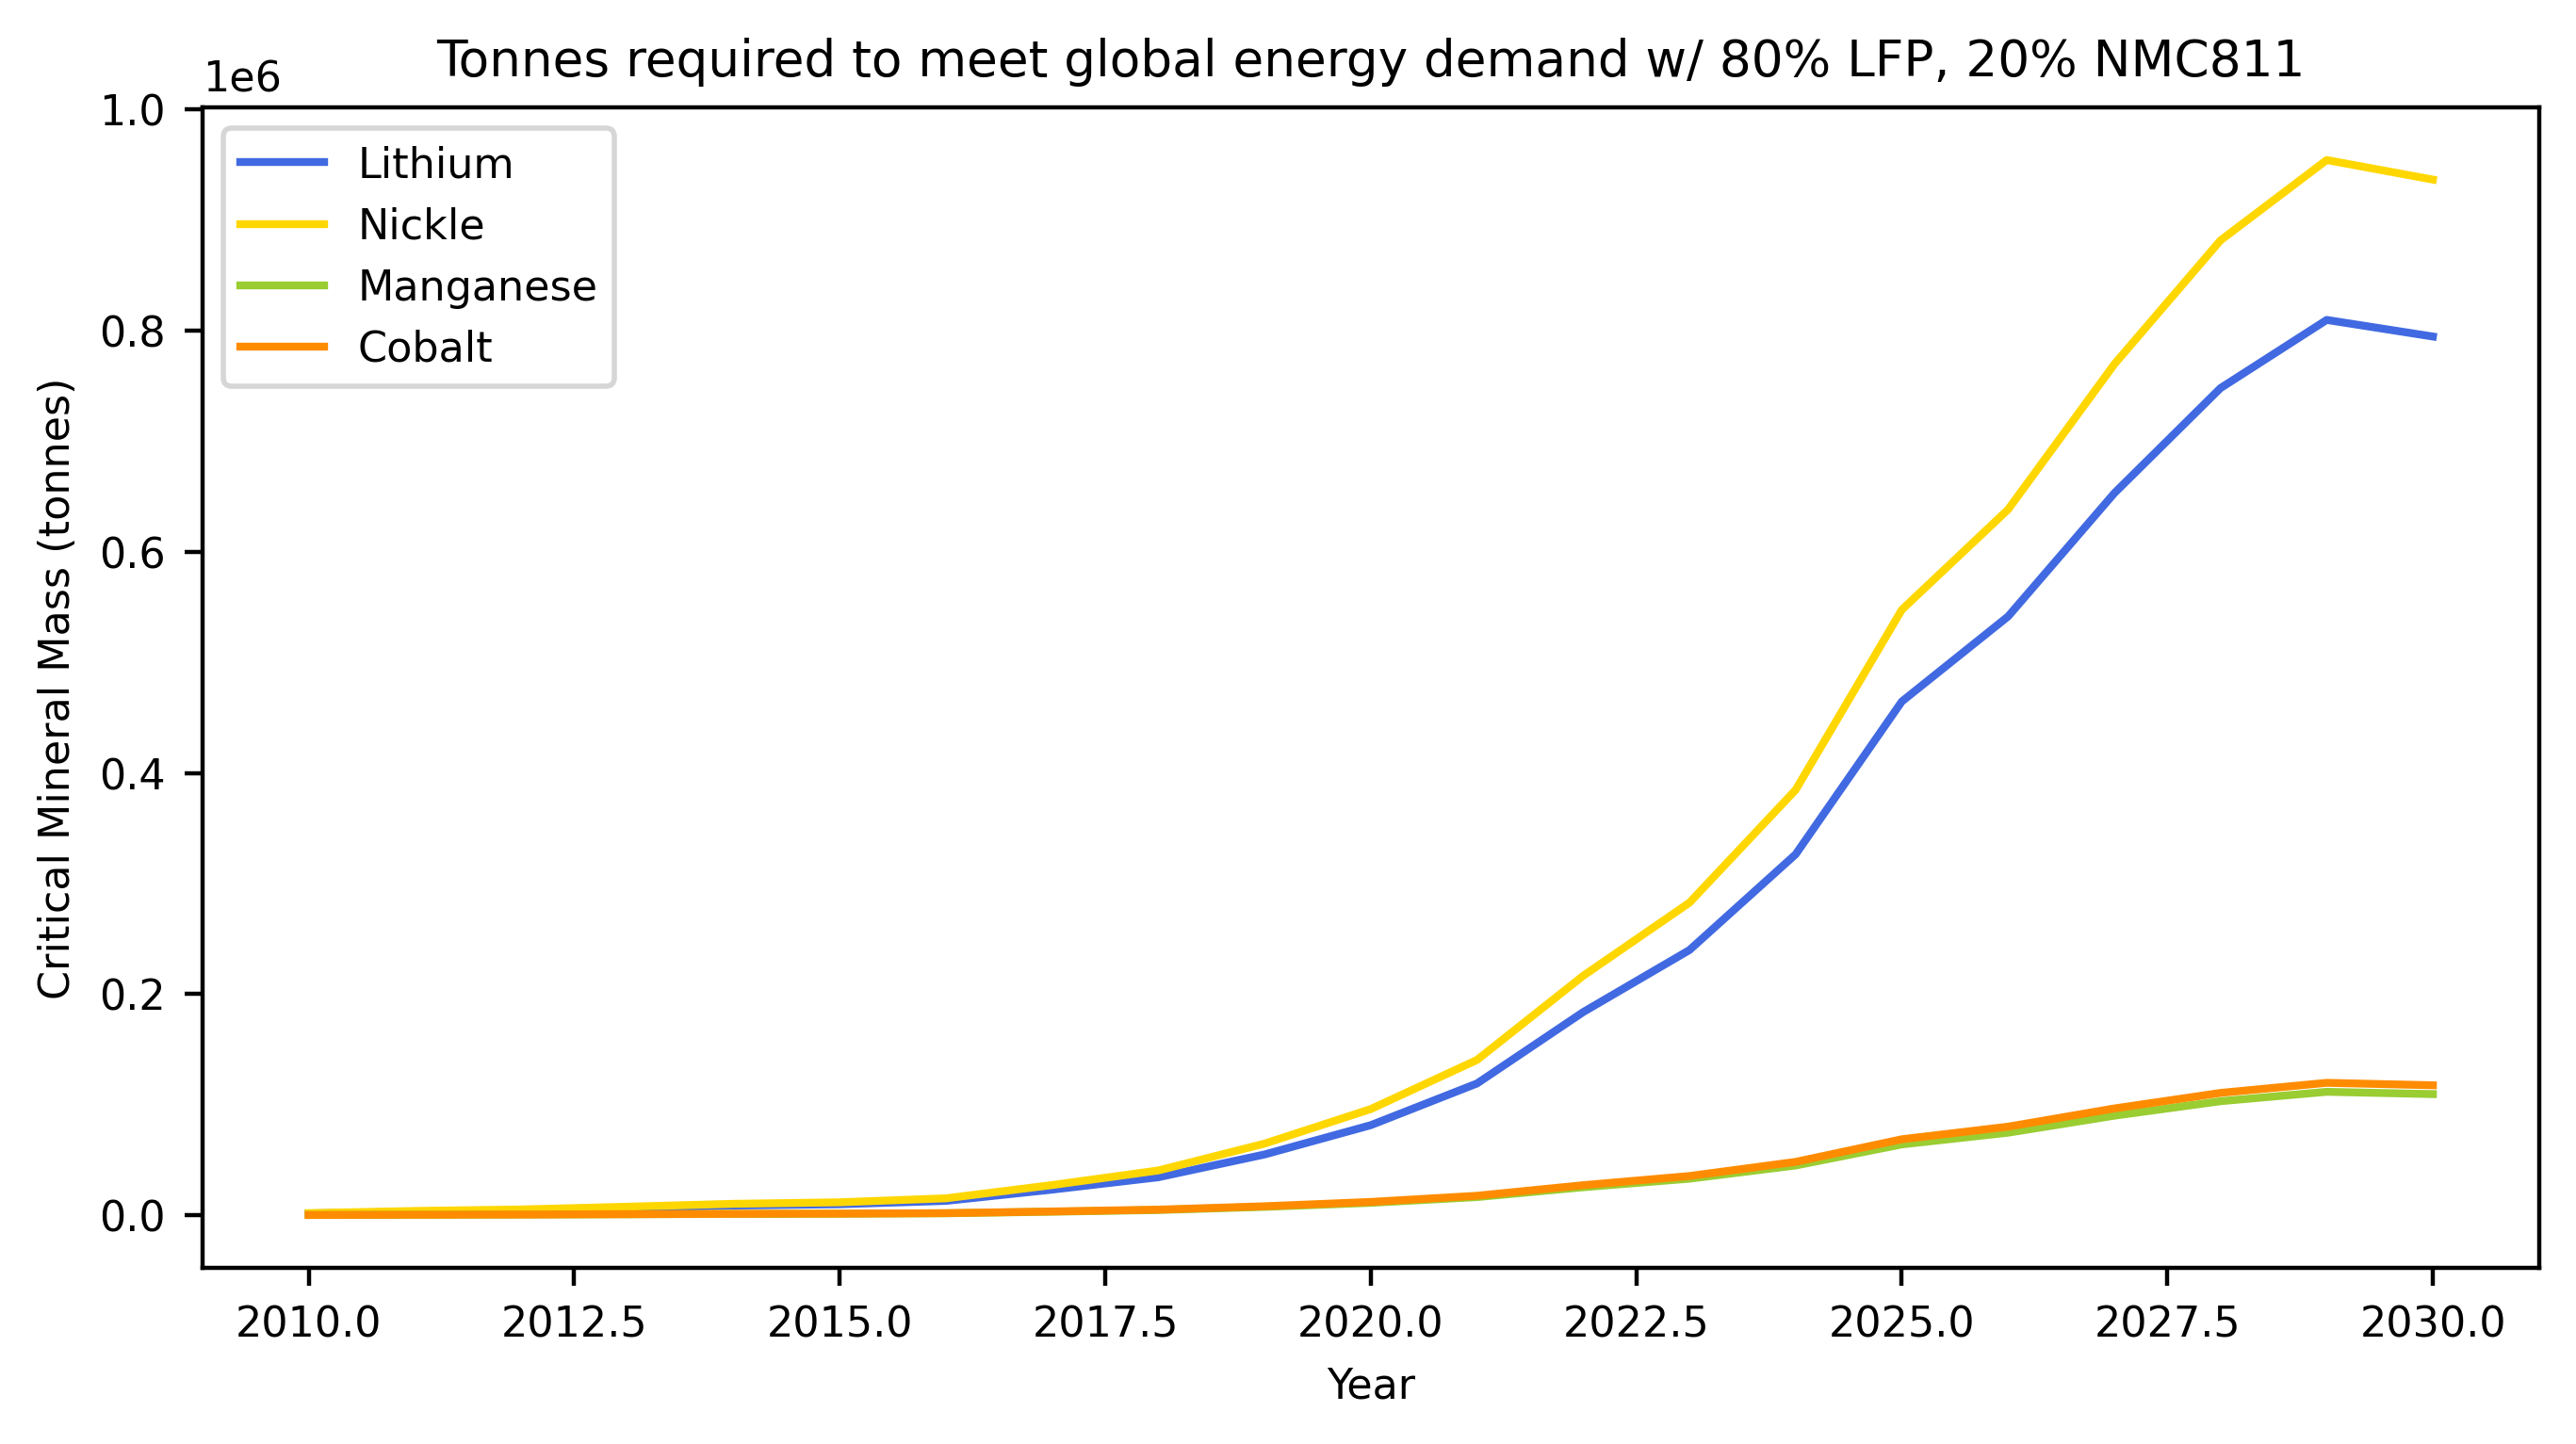

In [26]:
# example- say LFP meets 80% of need, NMC(811 only) is other 20% 

df_demand['gwh_LFP'] = df_demand['Capacity'].apply(lambda x: x * 0.8)
df_demand['gwh_NMC'] = df_demand['Capacity'].apply(lambda x: x * 0.2)

LFP_Li = [AM_calc(yr, 3.5, "LFP")[0] for yr in df_demand['gwh_LFP']]
NMC_Li = [AM_calc(yr, 3.5, "NMC811")[0] for yr in df_demand['gwh_NMC']]
total_Li = [i + j for i, j in zip(LFP_Li, NMC_Li)]
Ni_mass = [AM_calc(yr, 3.5, "NMC811")[1] for yr in df_demand['gwh_NMC']]
Mn_mass = [AM_calc(yr, 3.5, "NMC811")[2] for yr in df_demand['gwh_NMC']]
Co_mass = [AM_calc(yr, 3.5, "NMC811")[3] for yr in df_demand['gwh_NMC']]

plt.figure(dpi=400,figsize=(8, 4))
# plt.plot(df['Year'], LFP_Li, label = 'Lithium from LFP', color = 'midnightblue')
# plt.plot(df['Year'], NMC_Li, label = 'Lithium from NMC811', color = 'cornflowerblue')
plt.plot(df_demand['Year'], total_Li, label = 'Lithium', color = 'royalblue')
plt.plot(df_demand['Year'], Ni_mass, label = 'Nickle', color = 'gold')
plt.plot(df_demand['Year'], Mn_mass, label = 'Manganese', color = 'yellowgreen')
plt.plot(df_demand['Year'], Co_mass, label = 'Cobalt', color = 'darkorange')
plt.xlabel('Year')
plt.ylabel('Critical Mineral Mass (tonnes)')
plt.legend()
plt.title('Tonnes required to meet global energy demand w/ 80% LFP, 20% NMC811')
plt.show()

plotting CM masses required to meet historic demand (assuming 80% LFP, 20% NMC811) with varied electrode porosity: 

At t = 34.2523 and h = 5.23899e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 34.2541 and h = 7.65224e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.9205 and h = 5.66113e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 34.2477 and h = 7.46027e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 34.2612 and h = 5.75294e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.502 and h = 4.34559e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 6.12458 and h = 9.16891e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.43526 and h = 3.63444e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.44027 and h = 5.82771e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.275577 and h = 5.24087e-10, the corrector convergence failed repeatedly or with |h| = hmin.


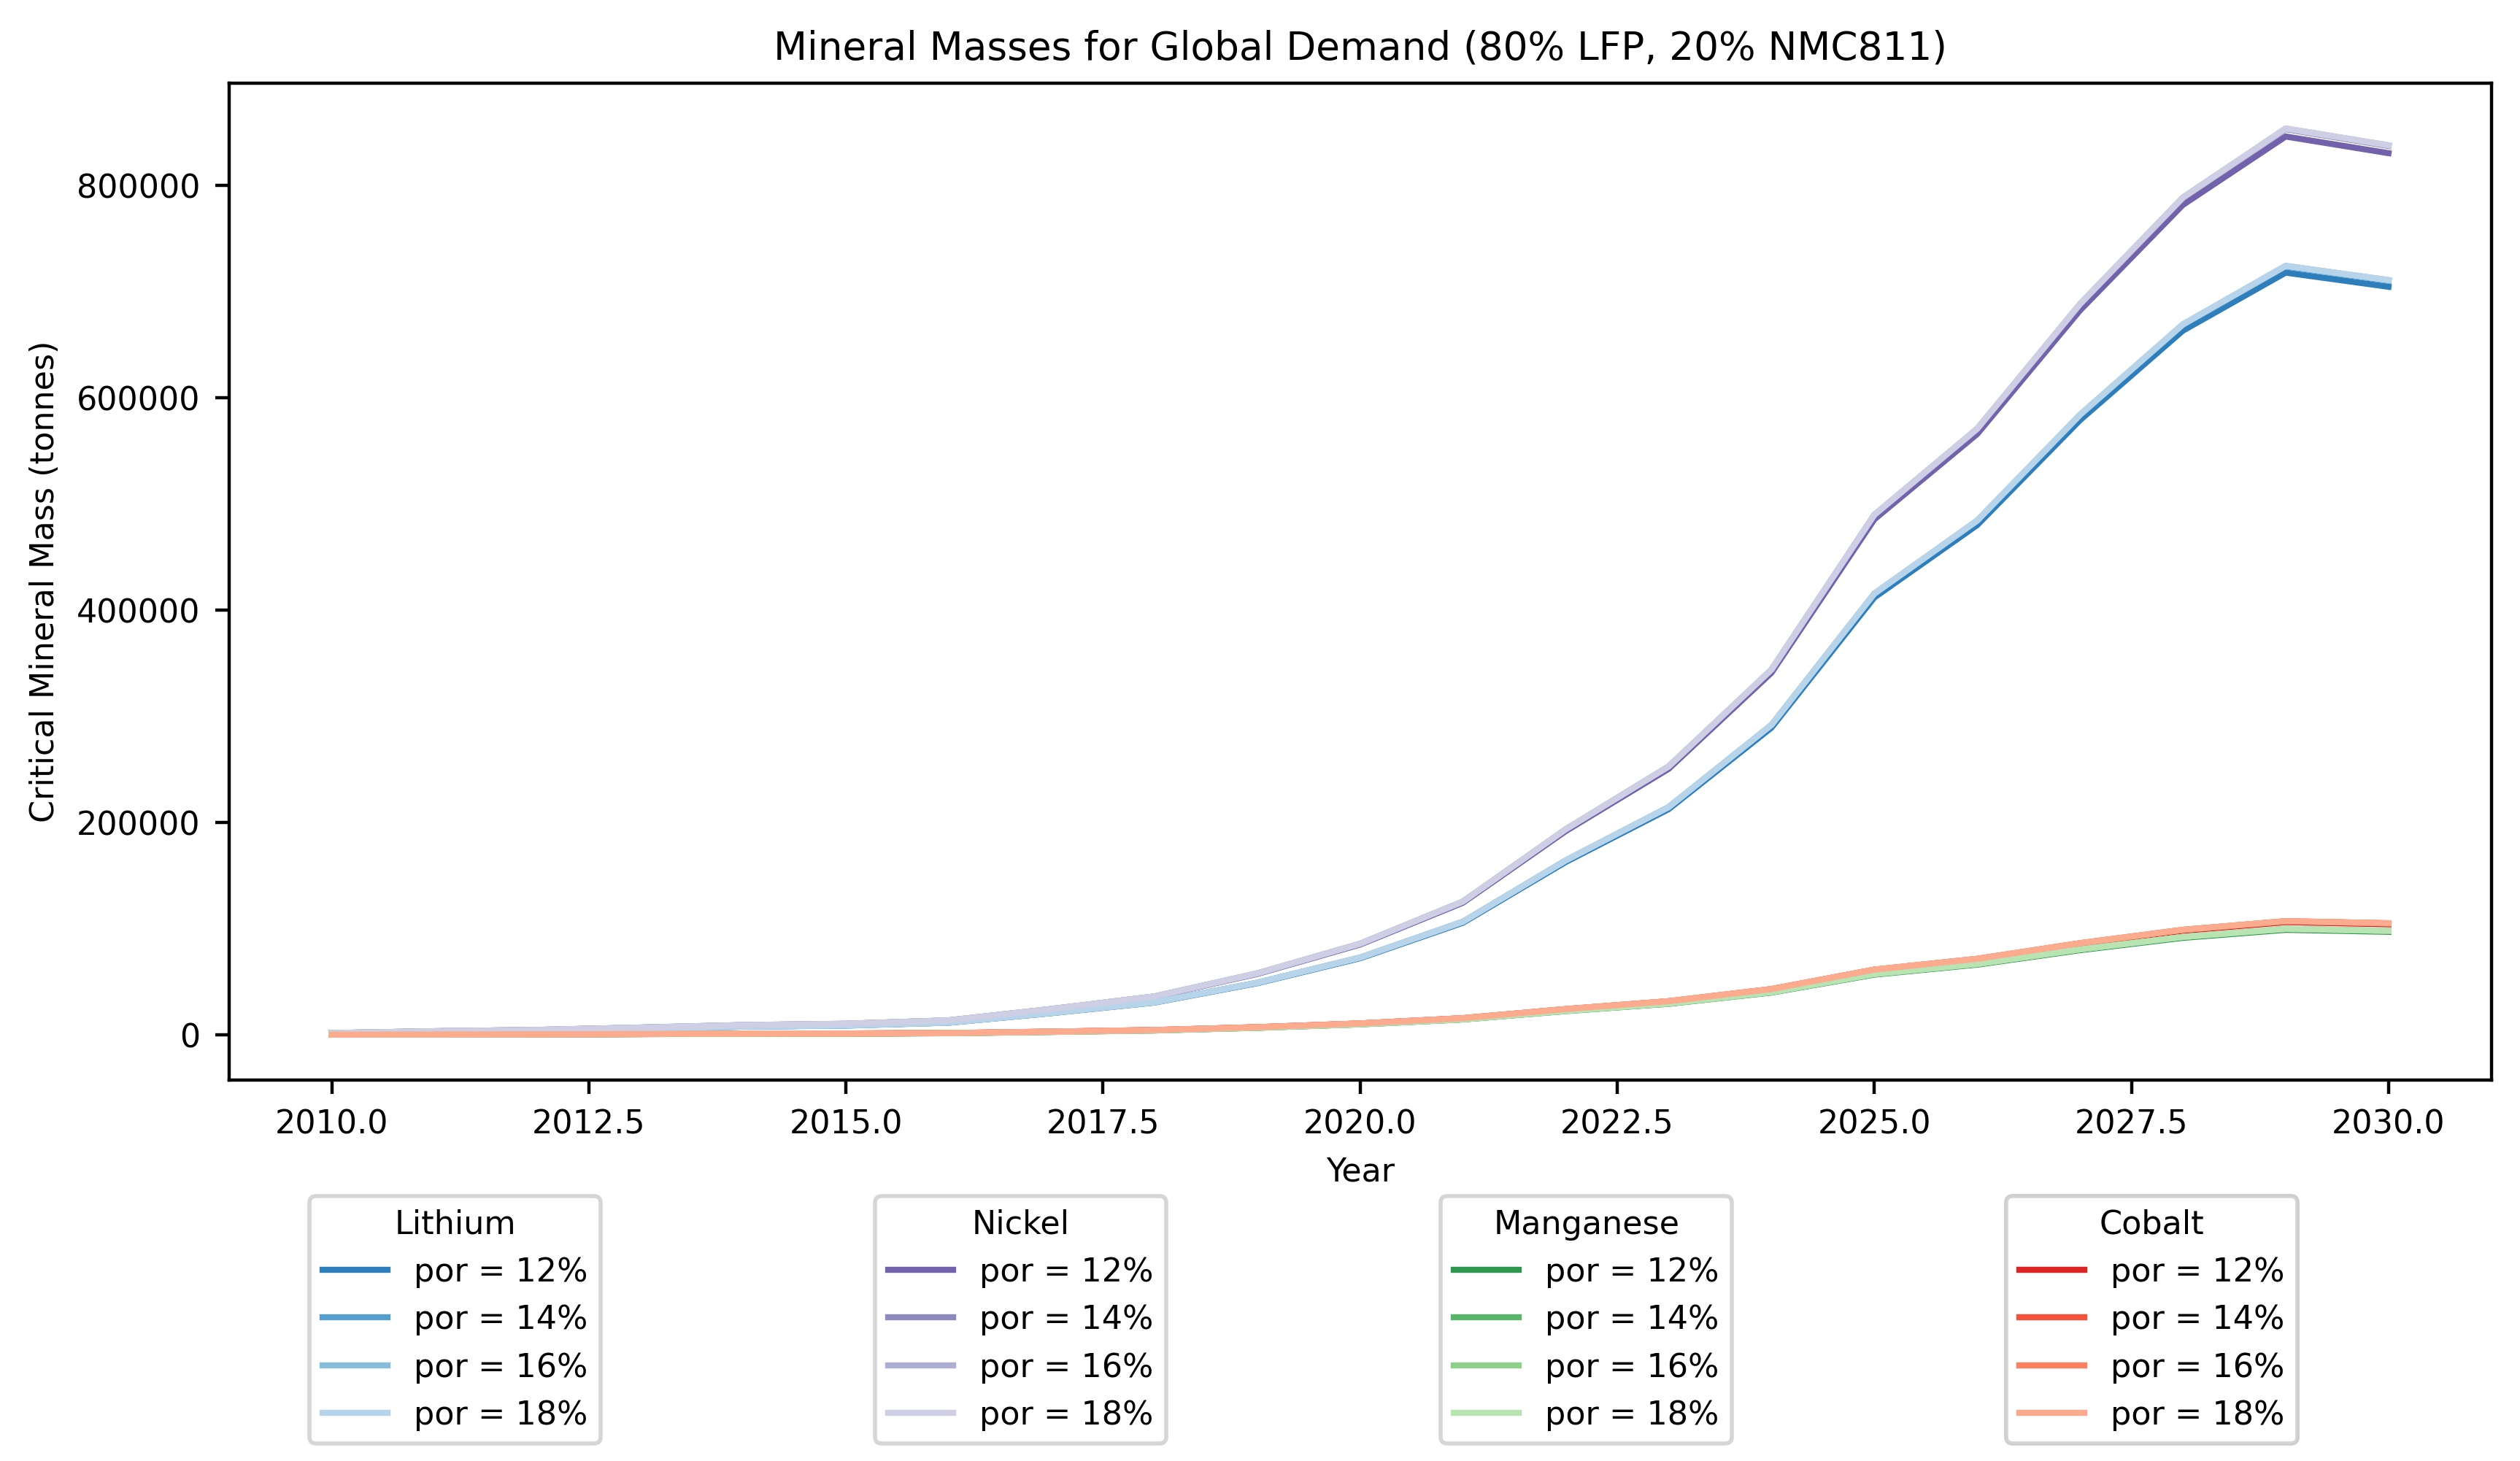

In [27]:
# now assume 80/20 is default breakdown, and vary porosity -> CM mass

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.12, 0.14, 0.16, 0.18]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.12, 0.14, 0.16, 0.18]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses

# energy required from NMC and LFP
df_demand['gwh_LFP'] = df_demand['Capacity'].apply(lambda x: x * 0.8) # 80% from LFP
df_demand['gwh_NMC'] = df_demand['Capacity'].apply(lambda x: x * 0.2) # 20% from NMC811

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Ni_lines = []
Mn_lines = []
Co_lines = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    line, = ax1.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)

ax1.set_xlabel('Year')
ax1.set_ylabel('Critical Mineral Mass (tonnes)')
ax1.set_title('Mineral Masses for Global Demand (80% LFP, 20% NMC811)')

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.35, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.60, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.85, -0.1), ncol = 1)
ax1.add_artist(co_legend)


plt.show()

plotting CM masses required to meet historic demand (using dynamic cathode type %) with varied electrode porosity and compare to global reserves for each mineral from S&P: 

At t = 576.211 and h = 3.45069e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 2.57702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.848 and h = 6.02513e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1204 and h = 3.88595e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.79081e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 1.89293e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.847 and h = 1.336e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1202 and h = 8.85124e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.92009e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 6.77626e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

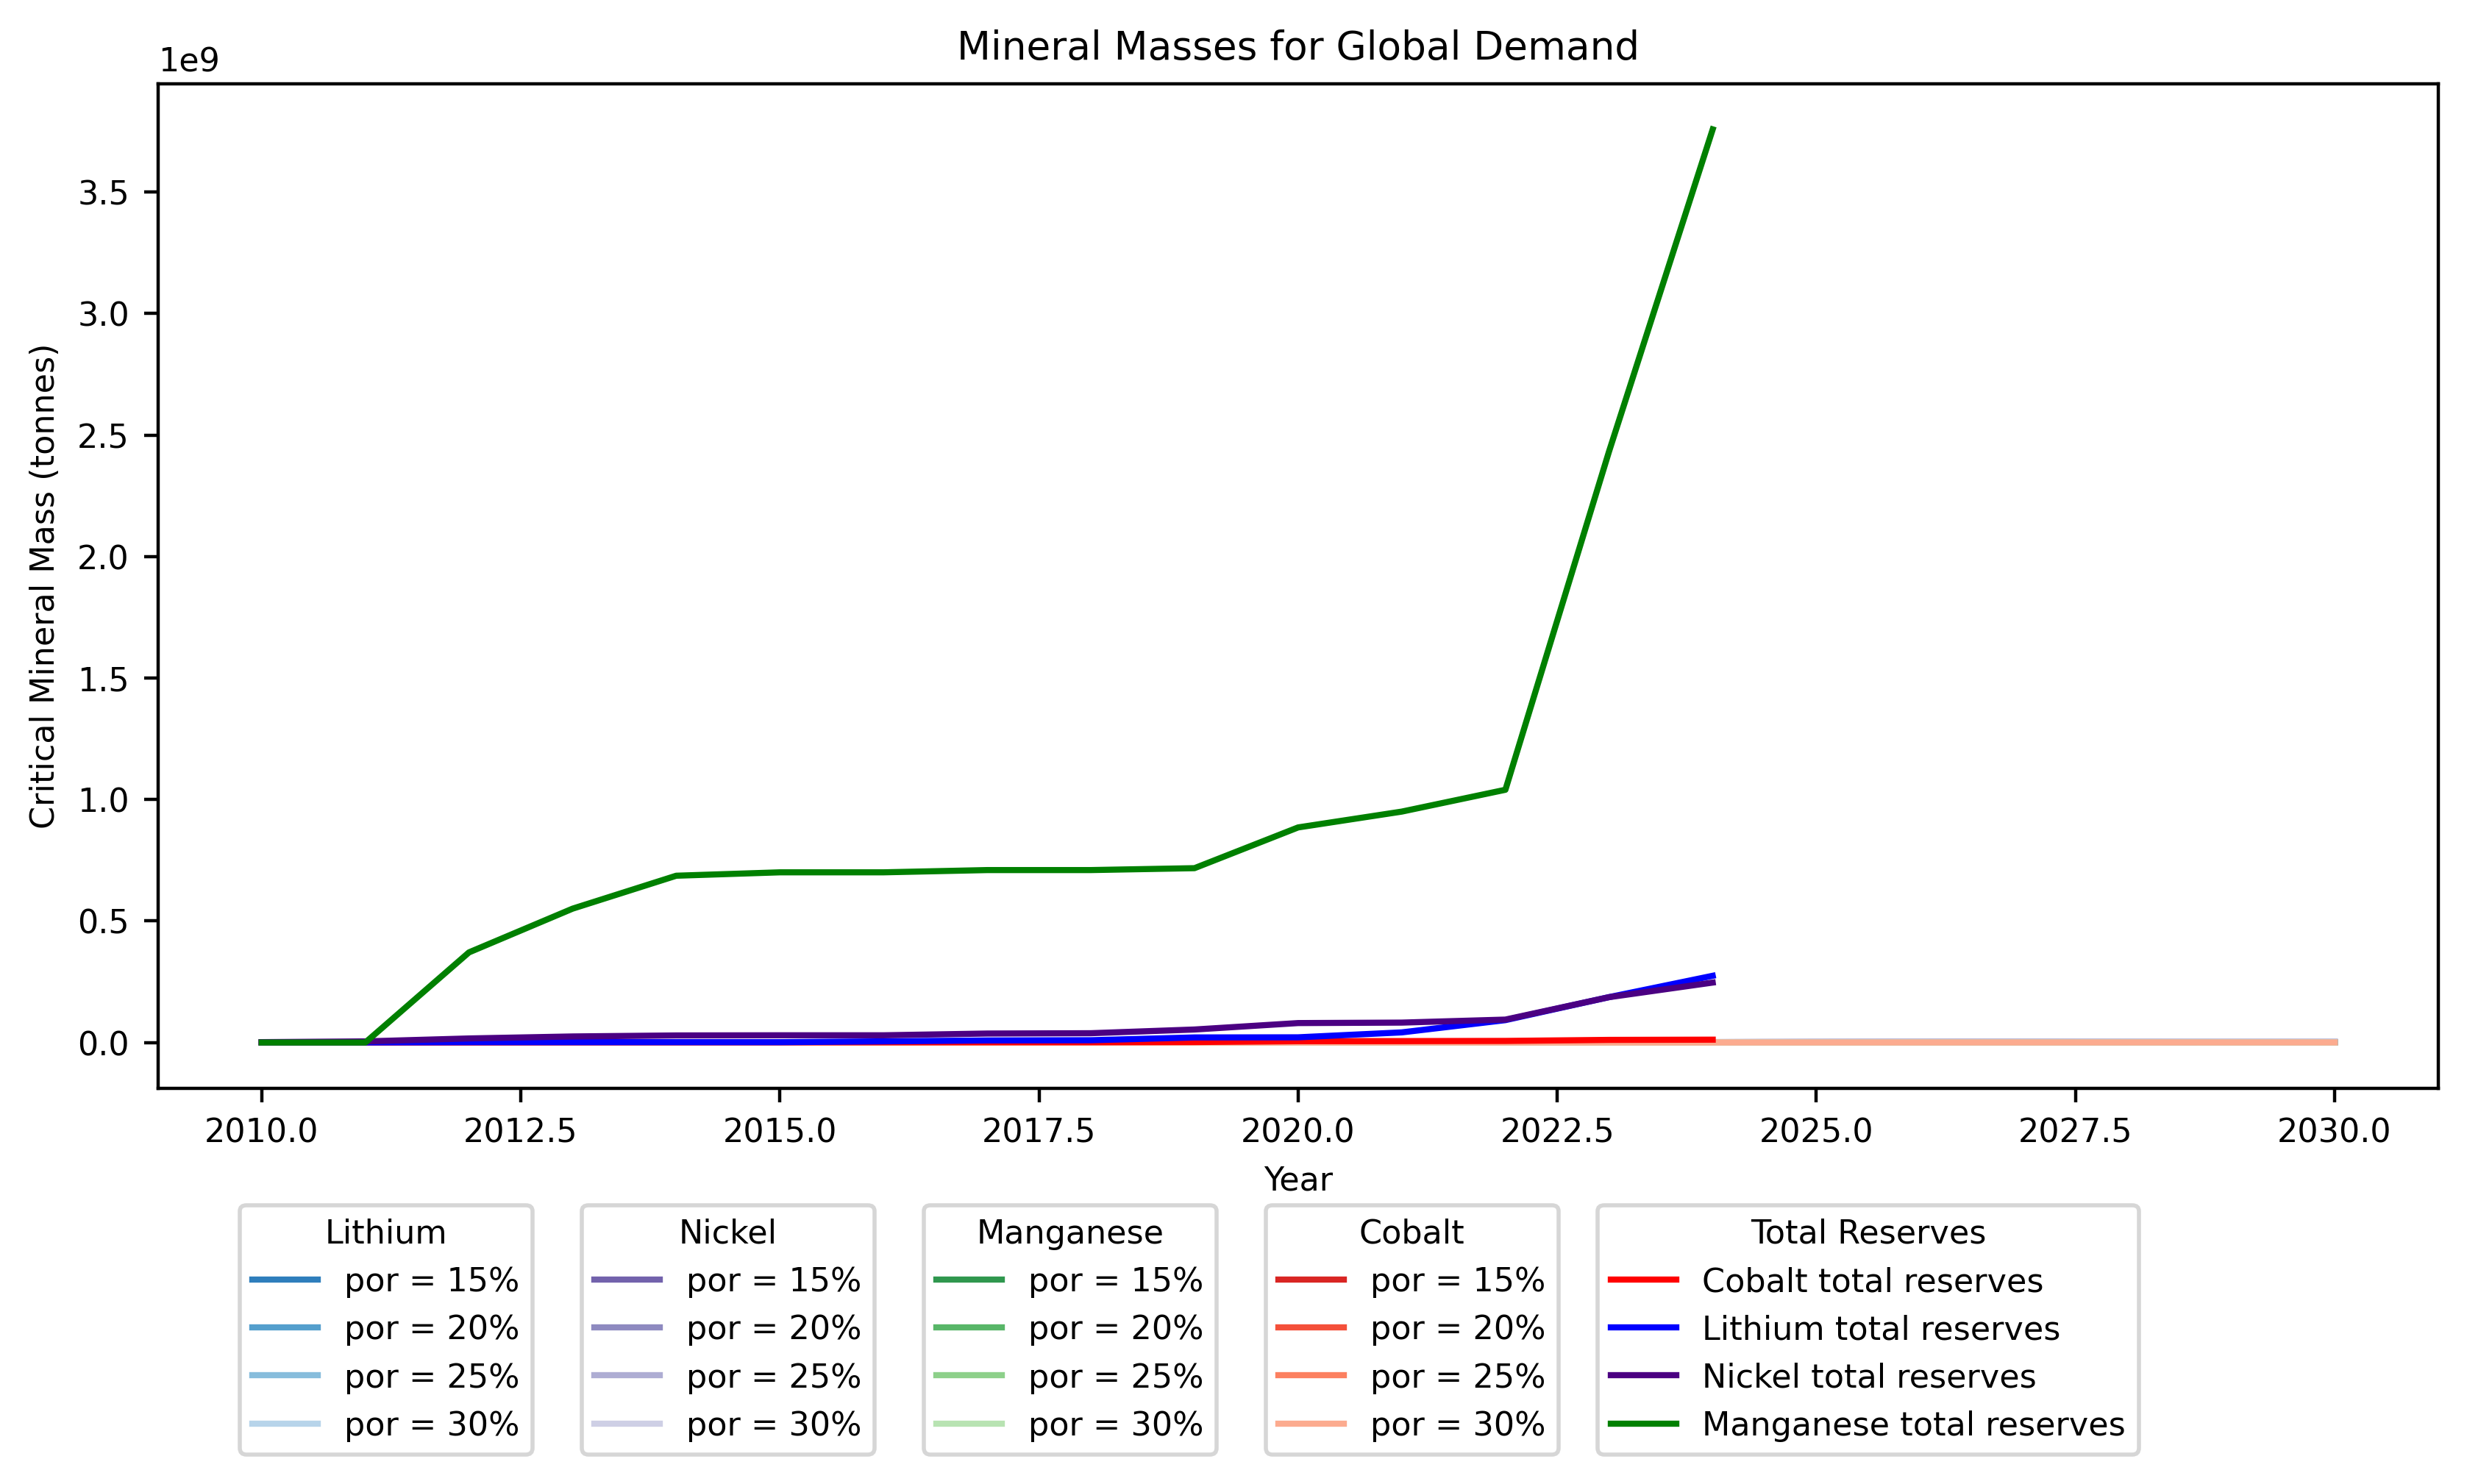

In [28]:
# now update to use 
    # 1) reserves of each mineral from S&P 
    # 2) percent cathode type at each year 

# section 1: reserves 

import os

directory = "/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/"

minerals = ["Manganese", "Lithium", "Cobalt", "Nickel"]

combined = None

filepath = os.path.join(directory, "SPGlobal_MetalsAndMiningProperties-Combined-Dec-2024.xlsx")
for i, mineral in enumerate(minerals):
    reserves_data = pd.read_excel(filepath, sheet_name = mineral)
    # making dates in excel sheet readable by pandas
    reserves_data["Reserves & Resources As Of Date"] = pd.to_datetime(reserves_data["Reserves & Resources As Of Date"])
    reserves_data["Primary Mineral"] = mineral
    # reformating dates to year only, then make new column 
    reserves_data["Year"] = reserves_data["Reserves & Resources As Of Date"].dt.year

    if i == 0:
        combined = reserves_data
        continue

    combined = pd.concat([combined, reserves_data], ignore_index=True)

combined = combined.sort_values(by = "Year").query("`Activity Status` == 'Active'")
combined["Property ID"] = combined["Property ID"].astype(int)

locations = pd.read_excel("/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/MiningPropertyLocations.xlsx")
coords = locations[["KeyMineProject","Latitude (degrees)", "Longitude (degrees)"]]

combined = combined.merge(coords, left_on = "Property ID", right_on="KeyMineProject" ,how = "inner")
combined.drop("KeyMineProject", axis=1, inplace=True, errors="ignore")

start_year = 2010
combined = combined[combined["Year"] >= start_year]

D = combined[["Year","Primary Mineral", "Primary Reserves and Resources"]]

D = D.groupby(["Year","Primary Mineral"], as_index=False).agg("sum")

all_years = D["Year"].unique()
all_minerals = D["Primary Mineral"].unique()
complete_index = pd.MultiIndex.from_product([all_years, all_minerals], names=["Year", "Primary Mineral"])

D = D.set_index(["Year", "Primary Mineral"]).reindex(complete_index, fill_value=0).reset_index()

D["Cumulative Reserves"] = D.groupby(["Primary Mineral"], as_index=False)["Primary Reserves and Resources"].agg("cumsum")

# section 2: modeling cathodes by porosity, output mass required for demand each year 

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

# % energy met by NMC, LFP each year

df_demand['gwh_LFP'] = df_demand["Capacity"] * df_demand["percent LFP"] 
df_demand['gwh_NMC'] = df_demand["Capacity"] * df_demand["percent NMC"] 

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Ni_lines = []
Mn_lines = []
Co_lines = []
reserves_lines = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    line, = ax1.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)

# add total reserves 

dict = {
    "Cobalt": "red",
    "Lithium": "blue",
    "Nickel": "Indigo",  
    "Manganese": "green"
}

for mineral, color in dict.items():
    mineral_set = D[D["Primary Mineral"] == mineral]
    line, = ax1.plot(mineral_set["Year"], mineral_set["Cumulative Reserves"], color=color, label = f'{mineral} total reserves')
    reserves_lines.append(line)

ax1.set_xlabel('Year')
ax1.set_ylabel('Critical Mineral Mass (tonnes)')
ax1.set_title('Mineral Masses for Global Demand')

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.25, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.40, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.55, -0.1), ncol = 1)
ax1.add_artist(co_legend)
reserves_legend = ax1.legend(handles=reserves_lines, title = "Total Reserves", loc = 'upper center', bbox_to_anchor = (0.75, -0.1), ncol = 1)


edits: restrict y axis, log scale, extend static reserves past 2025

At t = 576.211 and h = 3.45069e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 2.57702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.848 and h = 6.02513e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1204 and h = 3.88595e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.79081e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 1.89293e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.847 and h = 1.336e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1202 and h = 8.85124e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.92009e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 6.77626e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

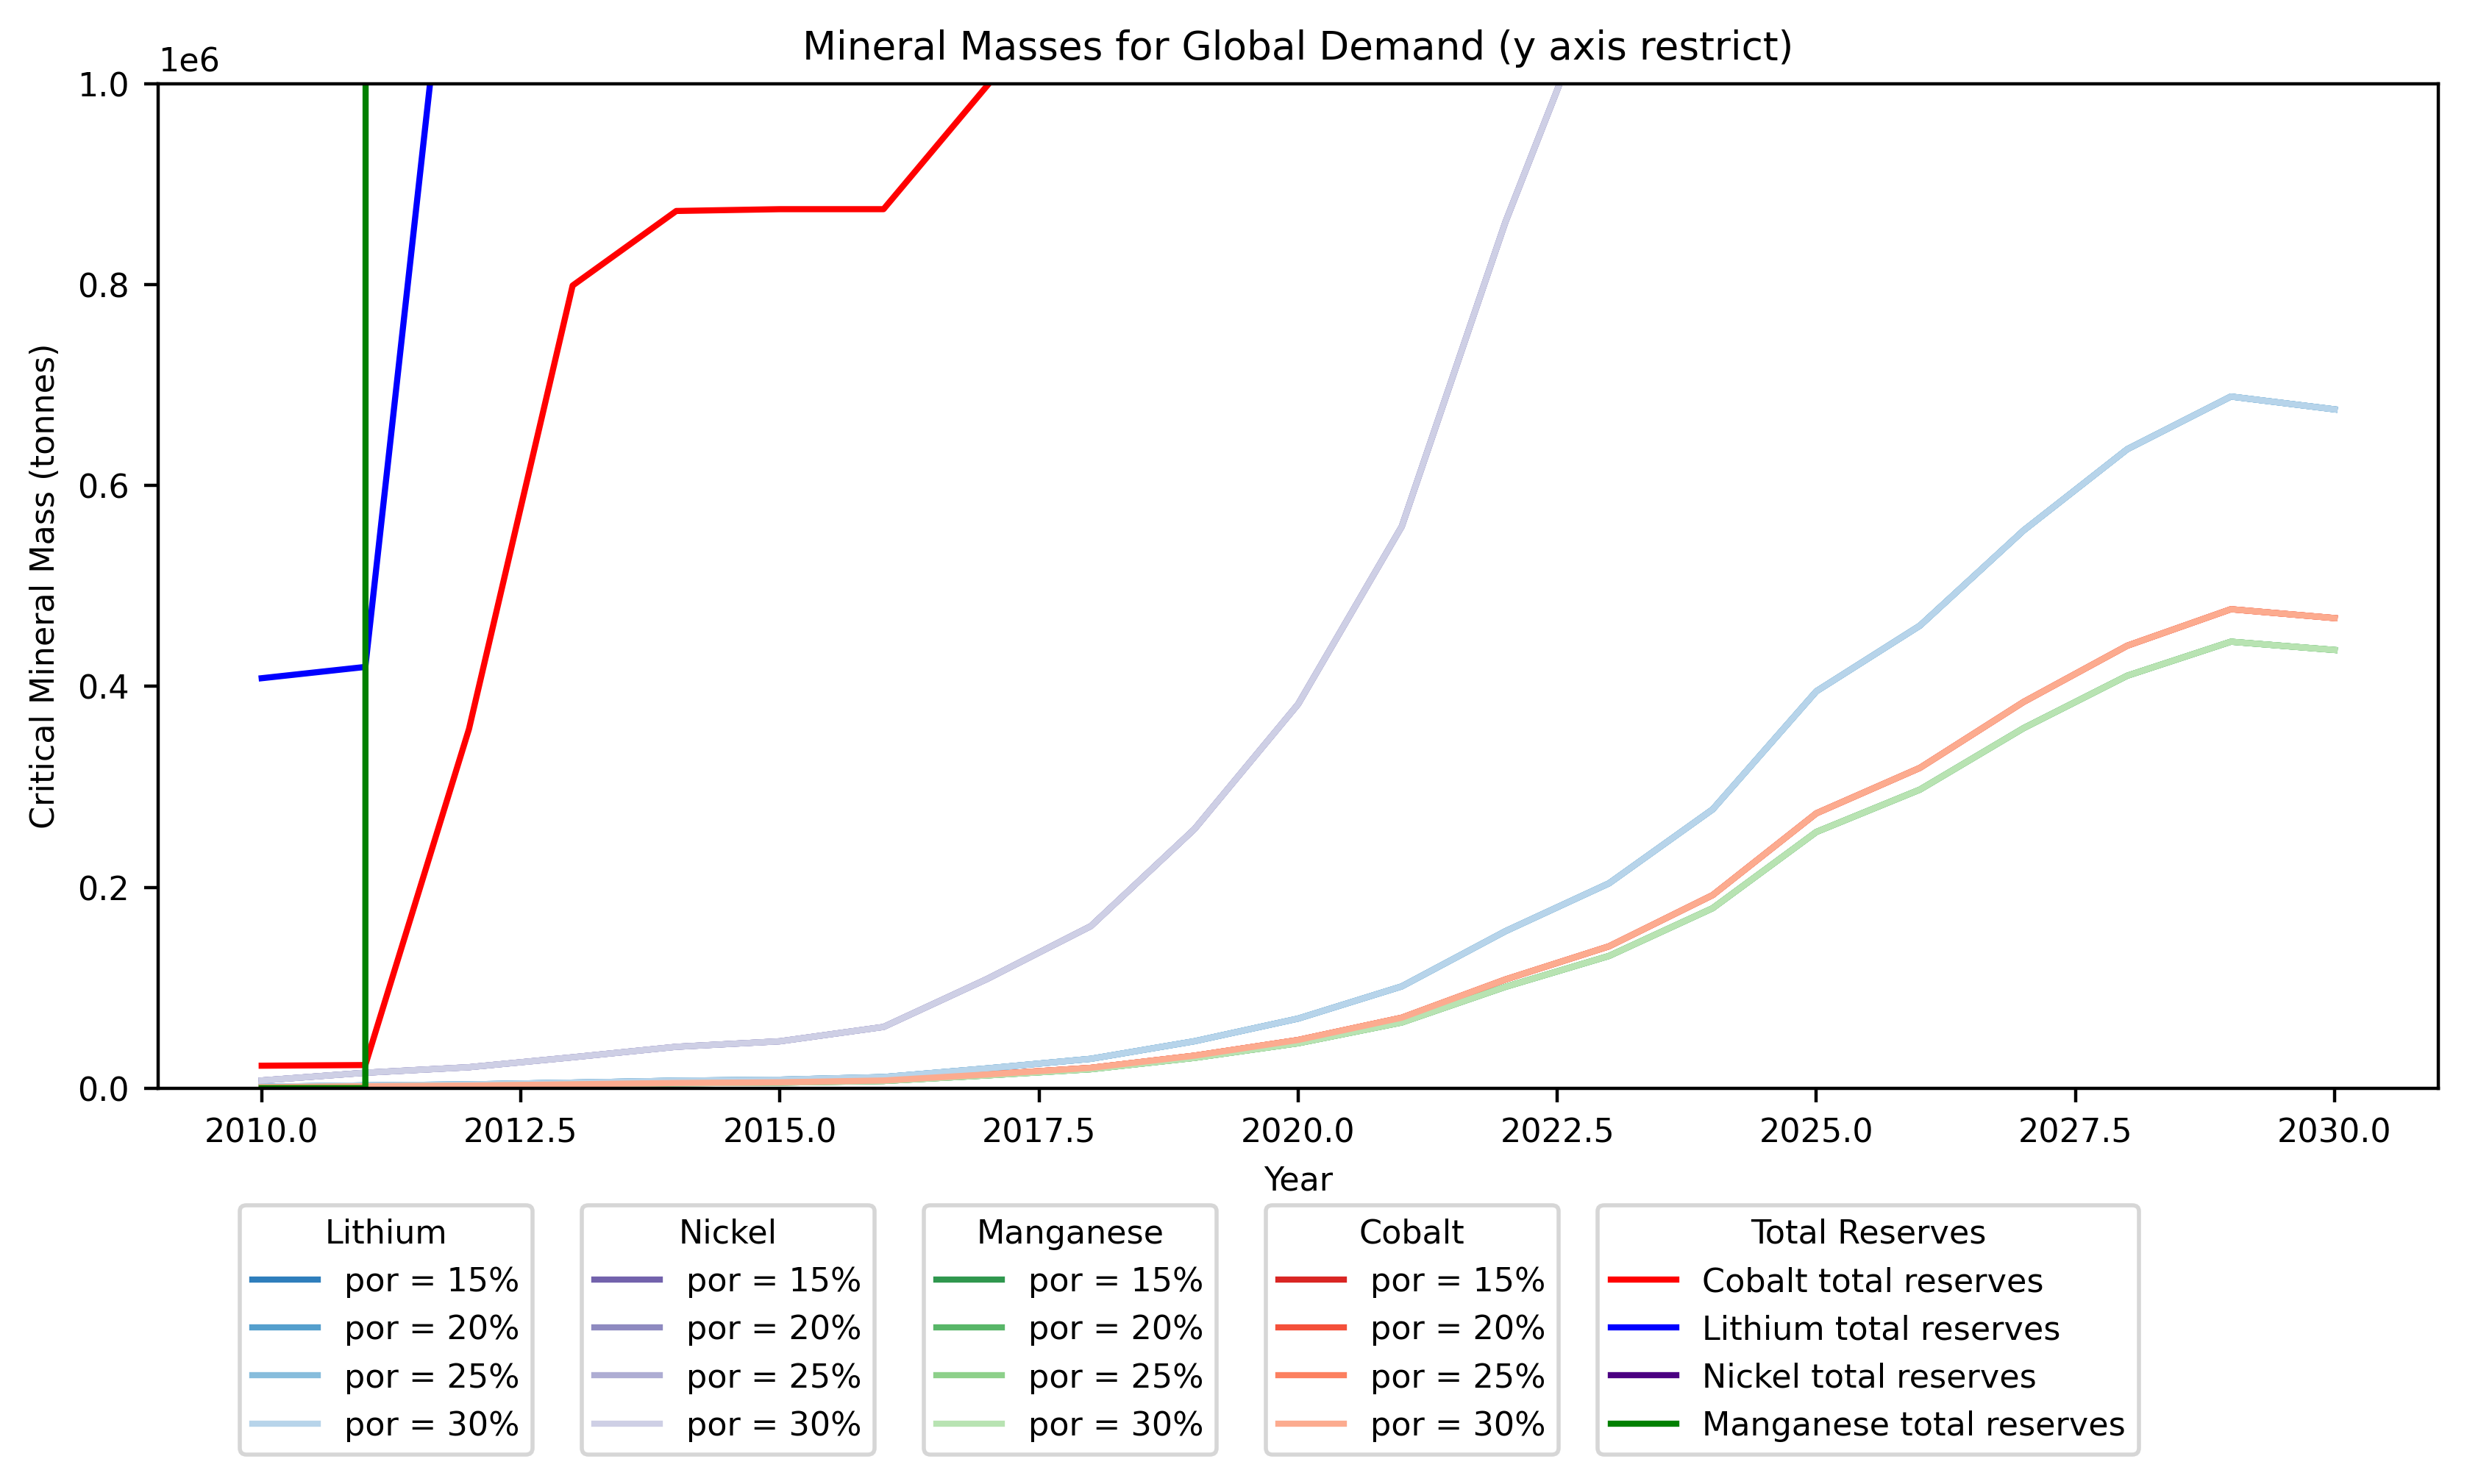

In [29]:
# restrict y axis 

# section 1: reserves 

import os

directory = "/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/"

minerals = ["Manganese", "Lithium", "Cobalt", "Nickel"]

combined = None

filepath = os.path.join(directory, "SPGlobal_MetalsAndMiningProperties-Combined-Dec-2024.xlsx")
for i, mineral in enumerate(minerals):
    reserves_data = pd.read_excel(filepath, sheet_name = mineral)
    # making dates in excel sheet readable by pandas
    reserves_data["Reserves & Resources As Of Date"] = pd.to_datetime(reserves_data["Reserves & Resources As Of Date"])
    reserves_data["Primary Mineral"] = mineral
    # reformating dates to year only, then make new column 
    reserves_data["Year"] = reserves_data["Reserves & Resources As Of Date"].dt.year

    if i == 0:
        combined = reserves_data
        continue

    combined = pd.concat([combined, reserves_data], ignore_index=True)

combined = combined.sort_values(by = "Year").query("`Activity Status` == 'Active'")
combined["Property ID"] = combined["Property ID"].astype(int)

locations = pd.read_excel("/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/MiningPropertyLocations.xlsx")
coords = locations[["KeyMineProject","Latitude (degrees)", "Longitude (degrees)"]]

combined = combined.merge(coords, left_on = "Property ID", right_on="KeyMineProject" ,how = "inner")
combined.drop("KeyMineProject", axis=1, inplace=True, errors="ignore")

start_year = 2010
combined = combined[combined["Year"] >= start_year]

D = combined[["Year","Primary Mineral", "Primary Reserves and Resources"]]

D = D.groupby(["Year","Primary Mineral"], as_index=False).agg("sum")

all_years = D["Year"].unique()
all_minerals = D["Primary Mineral"].unique()
complete_index = pd.MultiIndex.from_product([all_years, all_minerals], names=["Year", "Primary Mineral"])

D = D.set_index(["Year", "Primary Mineral"]).reindex(complete_index, fill_value=0).reset_index()

D["Cumulative Reserves"] = D.groupby(["Primary Mineral"], as_index=False)["Primary Reserves and Resources"].agg("cumsum")

# section 2: modeling cathodes by porosity, output mass required for demand each year 

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

# % energy met by NMC, LFP each year

df_demand['gwh_LFP'] = df_demand["Capacity"] * df_demand["percent LFP"] 
df_demand['gwh_NMC'] = df_demand["Capacity"] * df_demand["percent NMC"] 

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Ni_lines = []
Mn_lines = []
Co_lines = []
reserves_lines = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    line, = ax1.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)

# add total reserves 

dict = {
    "Cobalt": "red",
    "Lithium": "blue",
    "Nickel": "Indigo",  
    "Manganese": "green"
}

for mineral, color in dict.items():
    mineral_set = D[D["Primary Mineral"] == mineral]
    line, = ax1.plot(mineral_set["Year"], mineral_set["Cumulative Reserves"], color=color, label = f'{mineral} total reserves')
    reserves_lines.append(line)

ax1.set_xlabel('Year')
ax1.set_ylabel('Critical Mineral Mass (tonnes)')
ax1.set_title('Mineral Masses for Global Demand (y axis restrict)')
ax1.set_ylim(0, 1e6)

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.25, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.40, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.55, -0.1), ncol = 1)
ax1.add_artist(co_legend)
reserves_legend = ax1.legend(handles=reserves_lines, title = "Total Reserves", loc = 'upper center', bbox_to_anchor = (0.75, -0.1), ncol = 1)


At t = 576.211 and h = 3.45069e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 2.57702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.848 and h = 6.02513e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1204 and h = 3.88595e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.79081e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 1.89293e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.847 and h = 1.336e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1202 and h = 8.85124e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.92009e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 6.77626e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

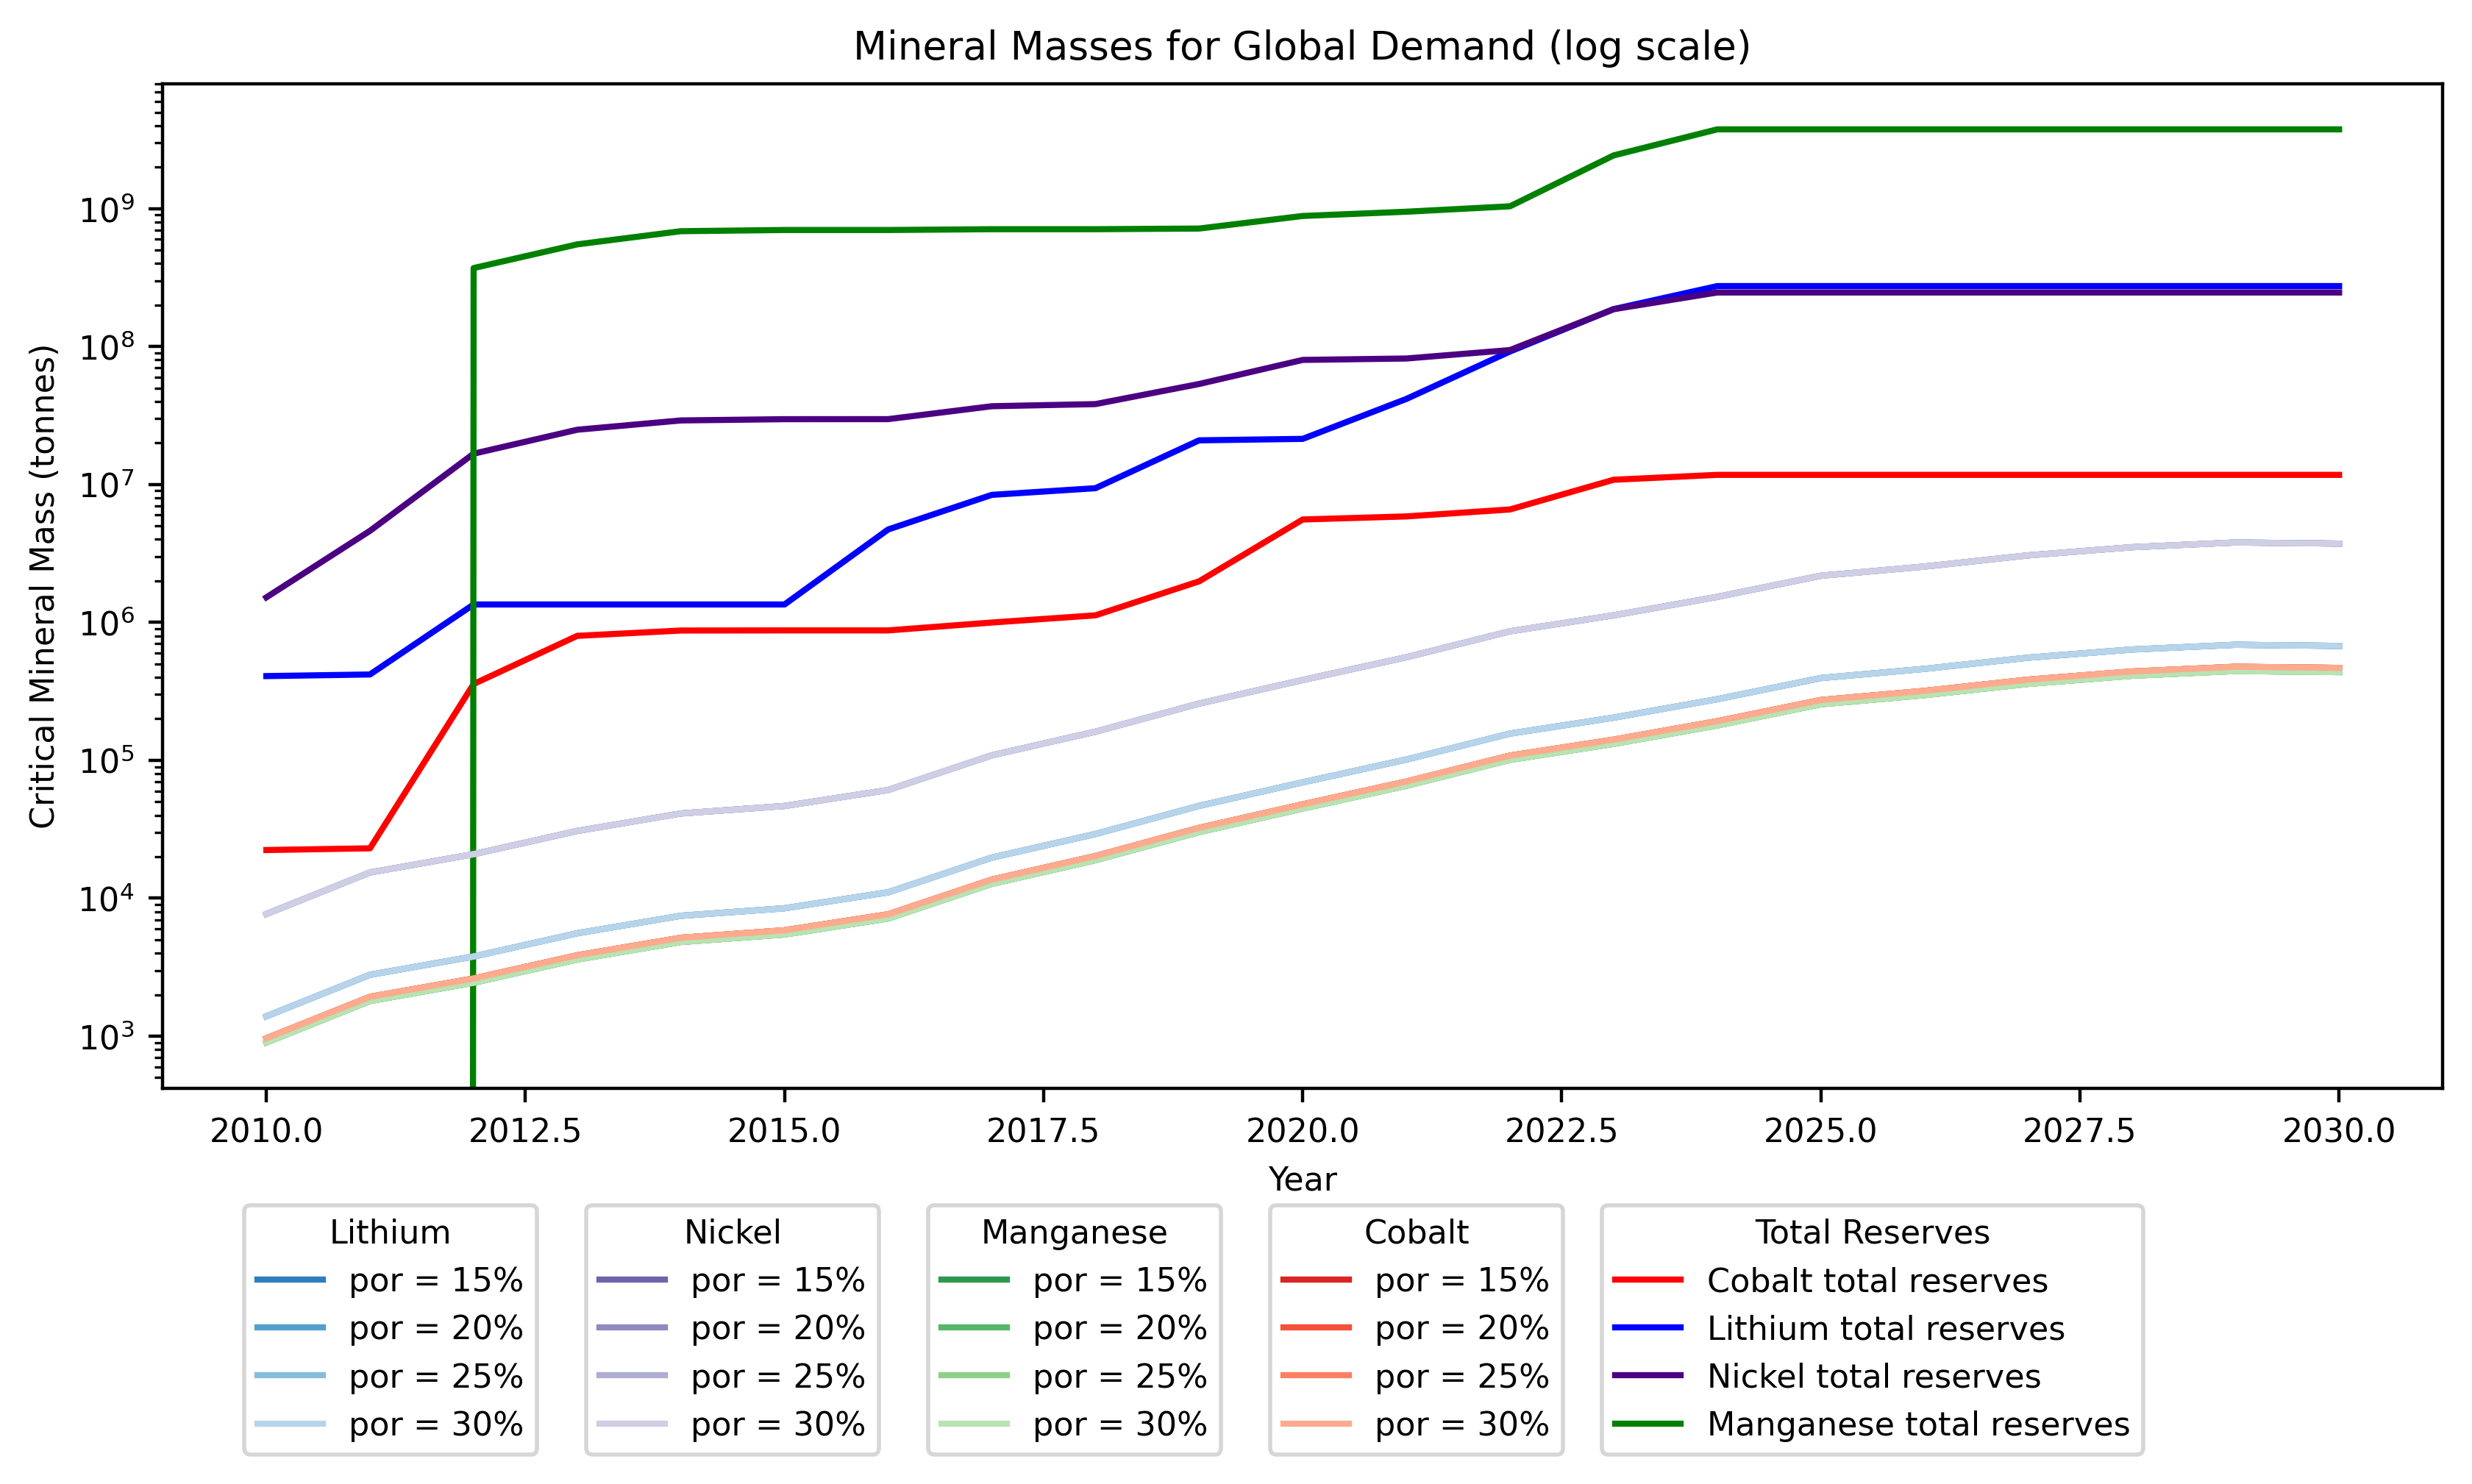

In [31]:
# log scale + assume static reserves past 2025

# section 1: modeling cathodes by porosity, output mass required for demand each year 

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

# % energy met by NMC, LFP each year

df_demand['gwh_LFP'] = df_demand["Capacity"] * df_demand["percent LFP"] 
df_demand['gwh_NMC'] = df_demand["Capacity"] * df_demand["percent NMC"] 

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Ni_lines = []
Mn_lines = []
Co_lines = []
reserves_lines = []
reserves_lines_extend = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  
ax1.set_yscale("log")

# add total reserves 

extended_reserves = "/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Individual/Isabela Galoustian/EPRI/reserves_extended.xlsx"
df_extended_reserves = pd.read_excel(extended_reserves)

dict = {
    "Cobalt": "red",
    "Lithium": "blue",
    "Nickel": "Indigo",  
    "Manganese": "green"
}

for mineral, color in dict.items():
    mineral_set_real = df_extended_reserves[df_extended_reserves["Primary Mineral"] == mineral].iloc[:63]
    line, = ax1.plot(mineral_set_real["Year"], mineral_set_real["Cumulative Reserves"], color=color, label = f'{mineral} total reserves')
    reserves_lines.append(line)

    mineral_set_extend = df_extended_reserves[df_extended_reserves["Primary Mineral"] == mineral].iloc[64:]
    line, = ax1.plot(mineral_set_extend["Year"], mineral_set_extend["Cumulative Reserves"], color=color, linestyle = 'dashed')
    reserves_lines_extend.append(line)

# plot masses

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    line, = ax1.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)
    #li_sensitivity = (li_mass_por_tot / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Lithium"]["Cumulative Reserves"]) * 100
    #print(f'Li por {p} sensitivity for 2010-2030: {li_sensitivity}')

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']] # for porosity 1, mass for all years
    line, = ax1.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)
    #ni_sensitivity = (Ni_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Nickel"]["Cumulative Reserves"]) * 100
    #print(f'Ni por {p} sensitivity for 2010-2030: {ni_sensitivity}')

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
    #mn_sensitivity = (Mn_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Manganese"]["Cumulative Reserves"]) * 100
    #print(f'Mn por {p} sensitivity for 2010-2030: {mn_sensitivity}')
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)
    #co_sensitivity = (Co_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Cobalt"]["Cumulative Reserves"]) * 100
    #print(f'Co por {p} sensitivity for 2010-2030: {Co_sensitivity}')

ax1.set_xlabel('Year')
ax1.set_ylabel('Critical Mineral Mass (tonnes)')
ax1.set_title('Mineral Masses for Global Demand (log scale)')

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.25, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.40, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.55, -0.1), ncol = 1)
ax1.add_artist(co_legend)
reserves_legend = ax1.legend(handles=reserves_lines, title = "Total Reserves", loc = 'upper center', bbox_to_anchor = (0.75, -0.1), ncol = 1)



add sensitivity factor (mass needed / mass in reserves at each year):

At t = 576.211 and h = 3.45069e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 2.57702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.848 and h = 6.02513e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1204 and h = 3.88595e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.79081e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 1.89293e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.847 and h = 1.336e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1202 and h = 8.85124e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.92009e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 6.77626e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

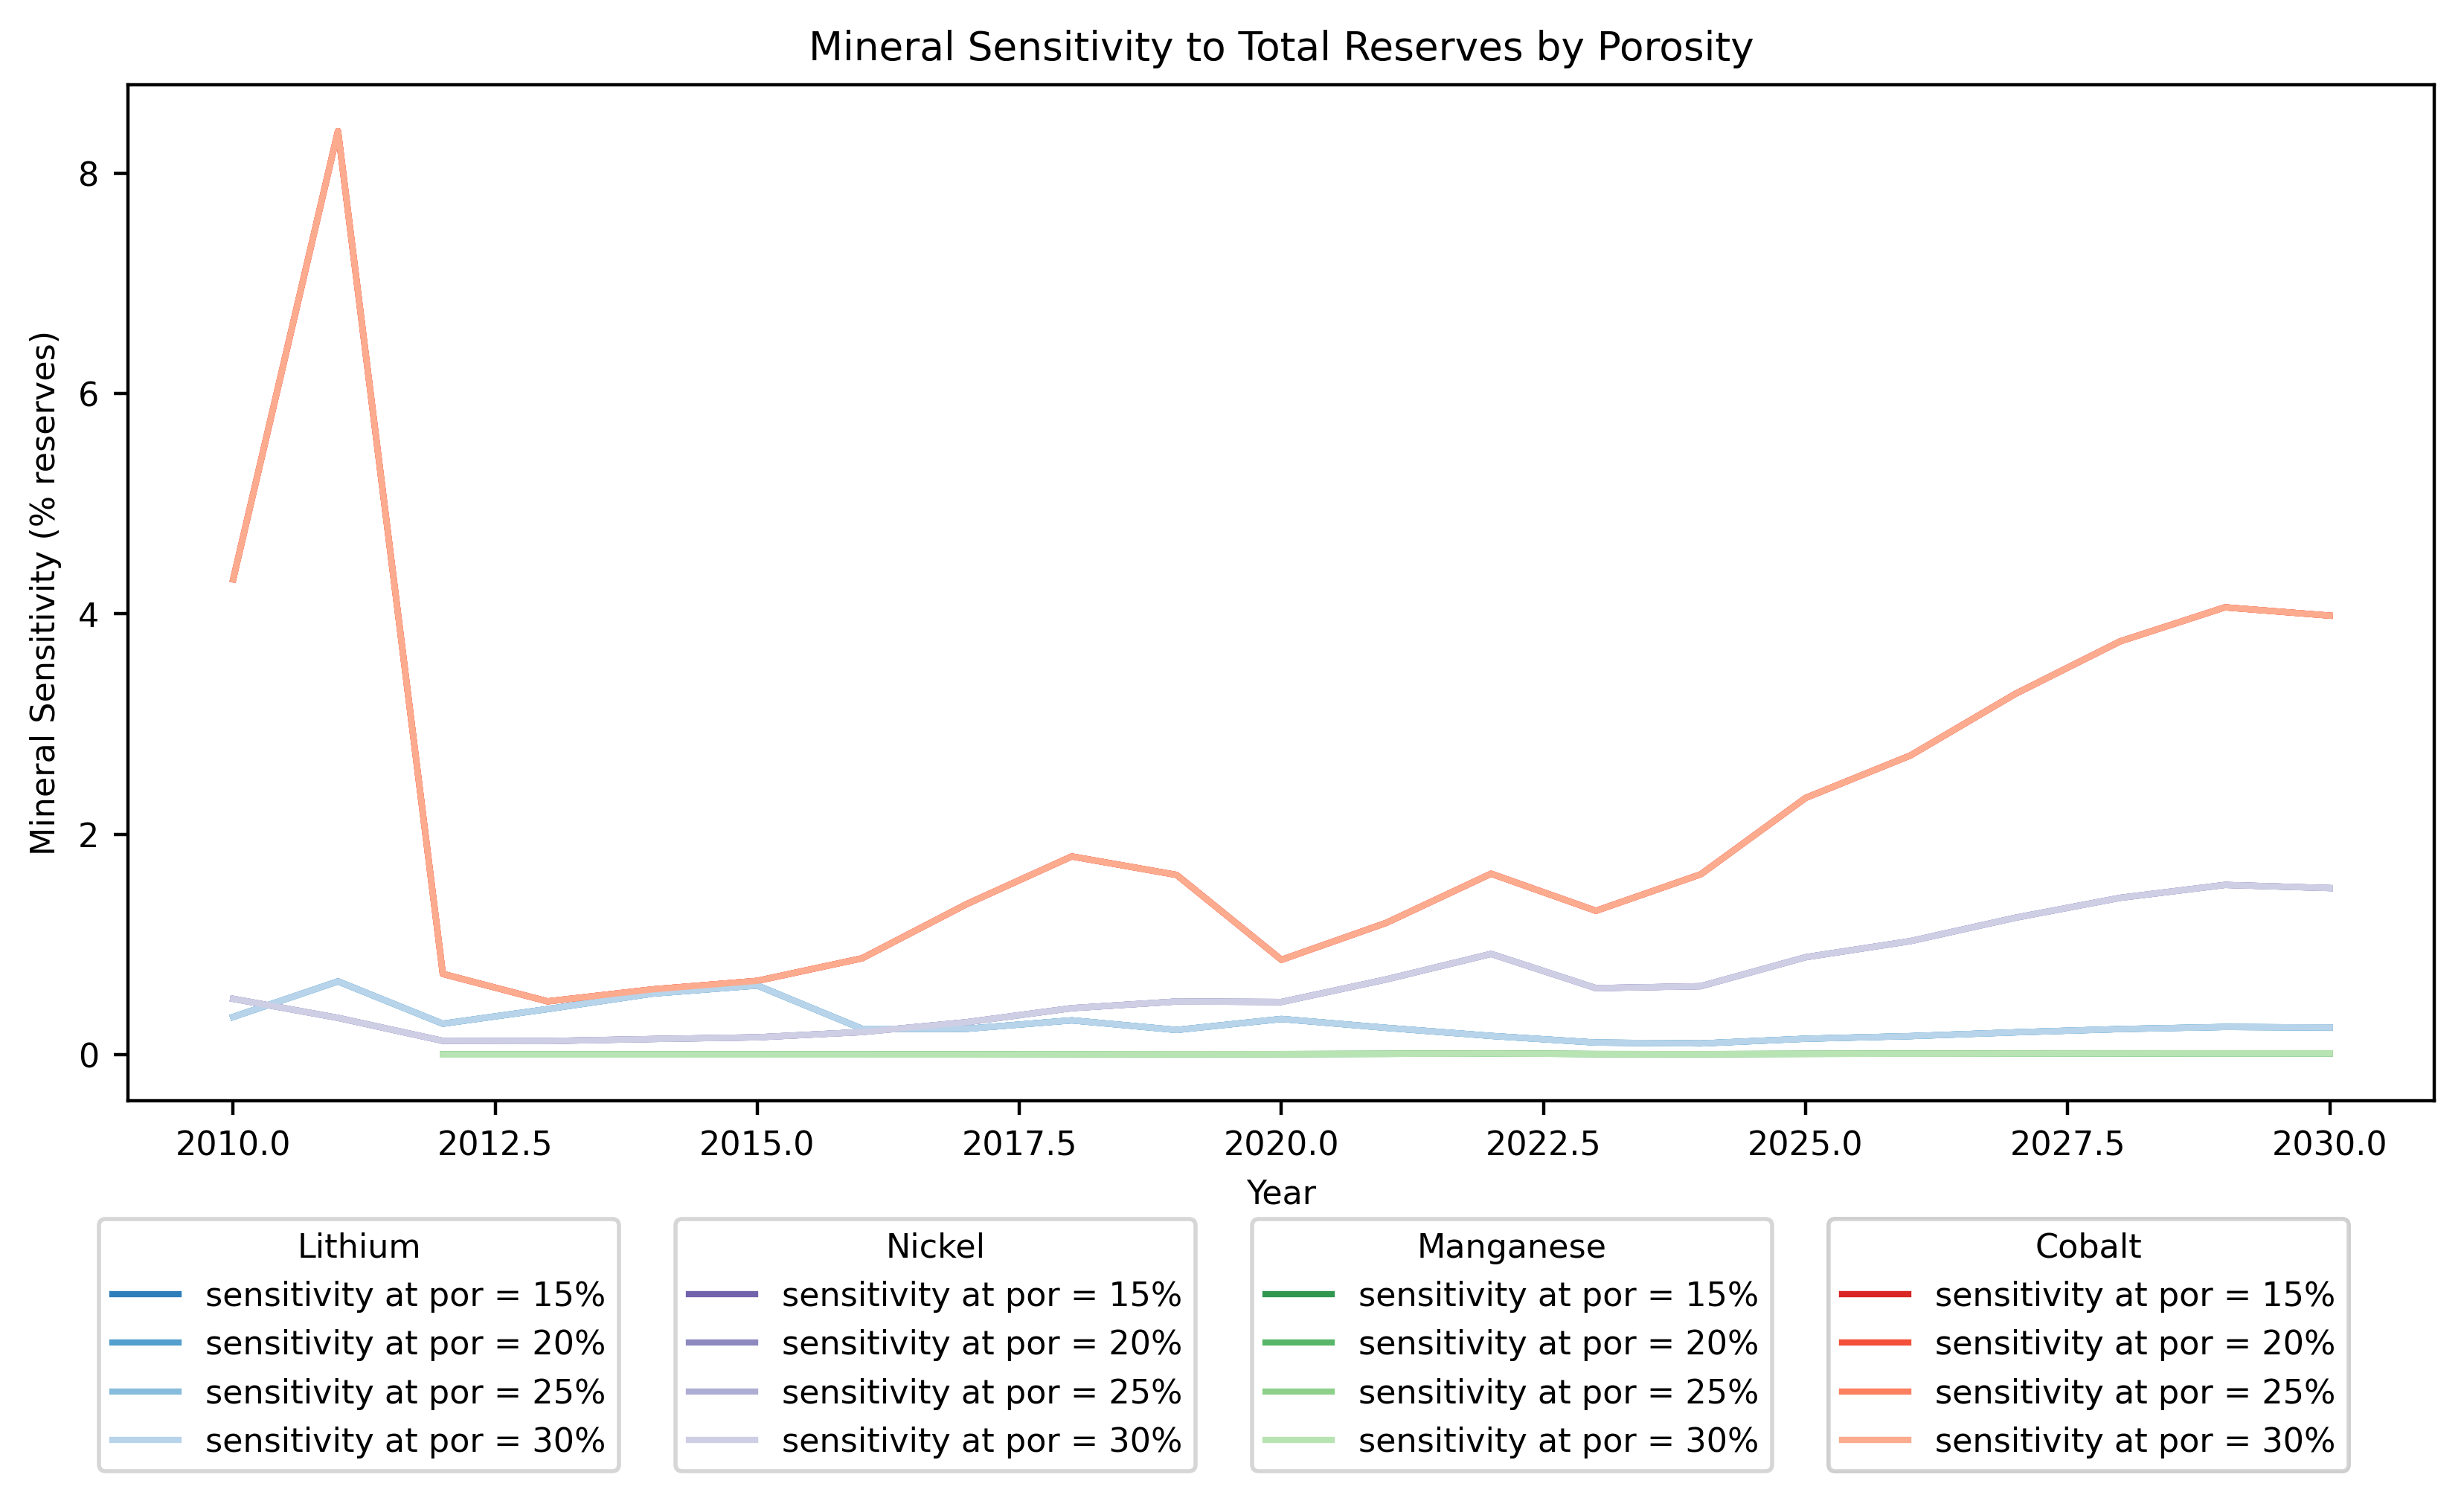

In [32]:
# plot just sensitivity of each element with porosity per year 

# section 1: modeling cathodes by porosity, output mass required for demand each year 

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

# % energy met by NMC, LFP each year

df_demand['gwh_LFP'] = df_demand["Capacity"] * df_demand["percent LFP"] 
df_demand['gwh_NMC'] = df_demand["Capacity"] * df_demand["percent NMC"] 

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Ni_lines = []
Mn_lines = []
Co_lines = []
reserves_lines = []
reserves_lines_extend = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  

# add total reserves 

extended_reserves = "/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Individual/Isabela Galoustian/EPRI/reserves_extended.xlsx"
df_extended_reserves = pd.read_excel(extended_reserves)

# plot masses

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    li_sensitivity = (Li_mass_por_tot / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Lithium"]["Cumulative Reserves"]) * 100
    line, = ax1.plot(df_demand['Year'], li_sensitivity, label = f'sensitivity at por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']] 
    ni_sensitivity = (Ni_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Nickel"]["Cumulative Reserves"]) * 100
    line, = ax1.plot(df_demand['Year'], ni_sensitivity, label = f'sensitivity at por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    mn_sensitivity = (Mn_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Manganese"]["Cumulative Reserves"]) * 100
    line, = ax1.plot(df_demand['Year'], mn_sensitivity, label = f'sensitivity at por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    co_sensitivity = (Co_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Cobalt"]["Cumulative Reserves"]) * 100
    line, = ax1.plot(df_demand['Year'], co_sensitivity, label = f'sensitivity at por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)

ax1.set_xlabel('Year')
ax1.set_ylabel('Mineral Sensitivity (% reserves)')
ax1.set_title('Mineral Sensitivity to Total Reserves by Porosity')

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.35, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.60, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.85, -0.1), ncol = 1)
ax1.add_artist(co_legend)



At t = 576.211 and h = 3.45069e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 2.57702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.848 and h = 6.02513e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1204 and h = 3.88595e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.79081e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 1.89293e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 139.847 and h = 1.336e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.1202 and h = 8.85124e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 576.211 and h = 1.92009e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.302 and h = 6.77626e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

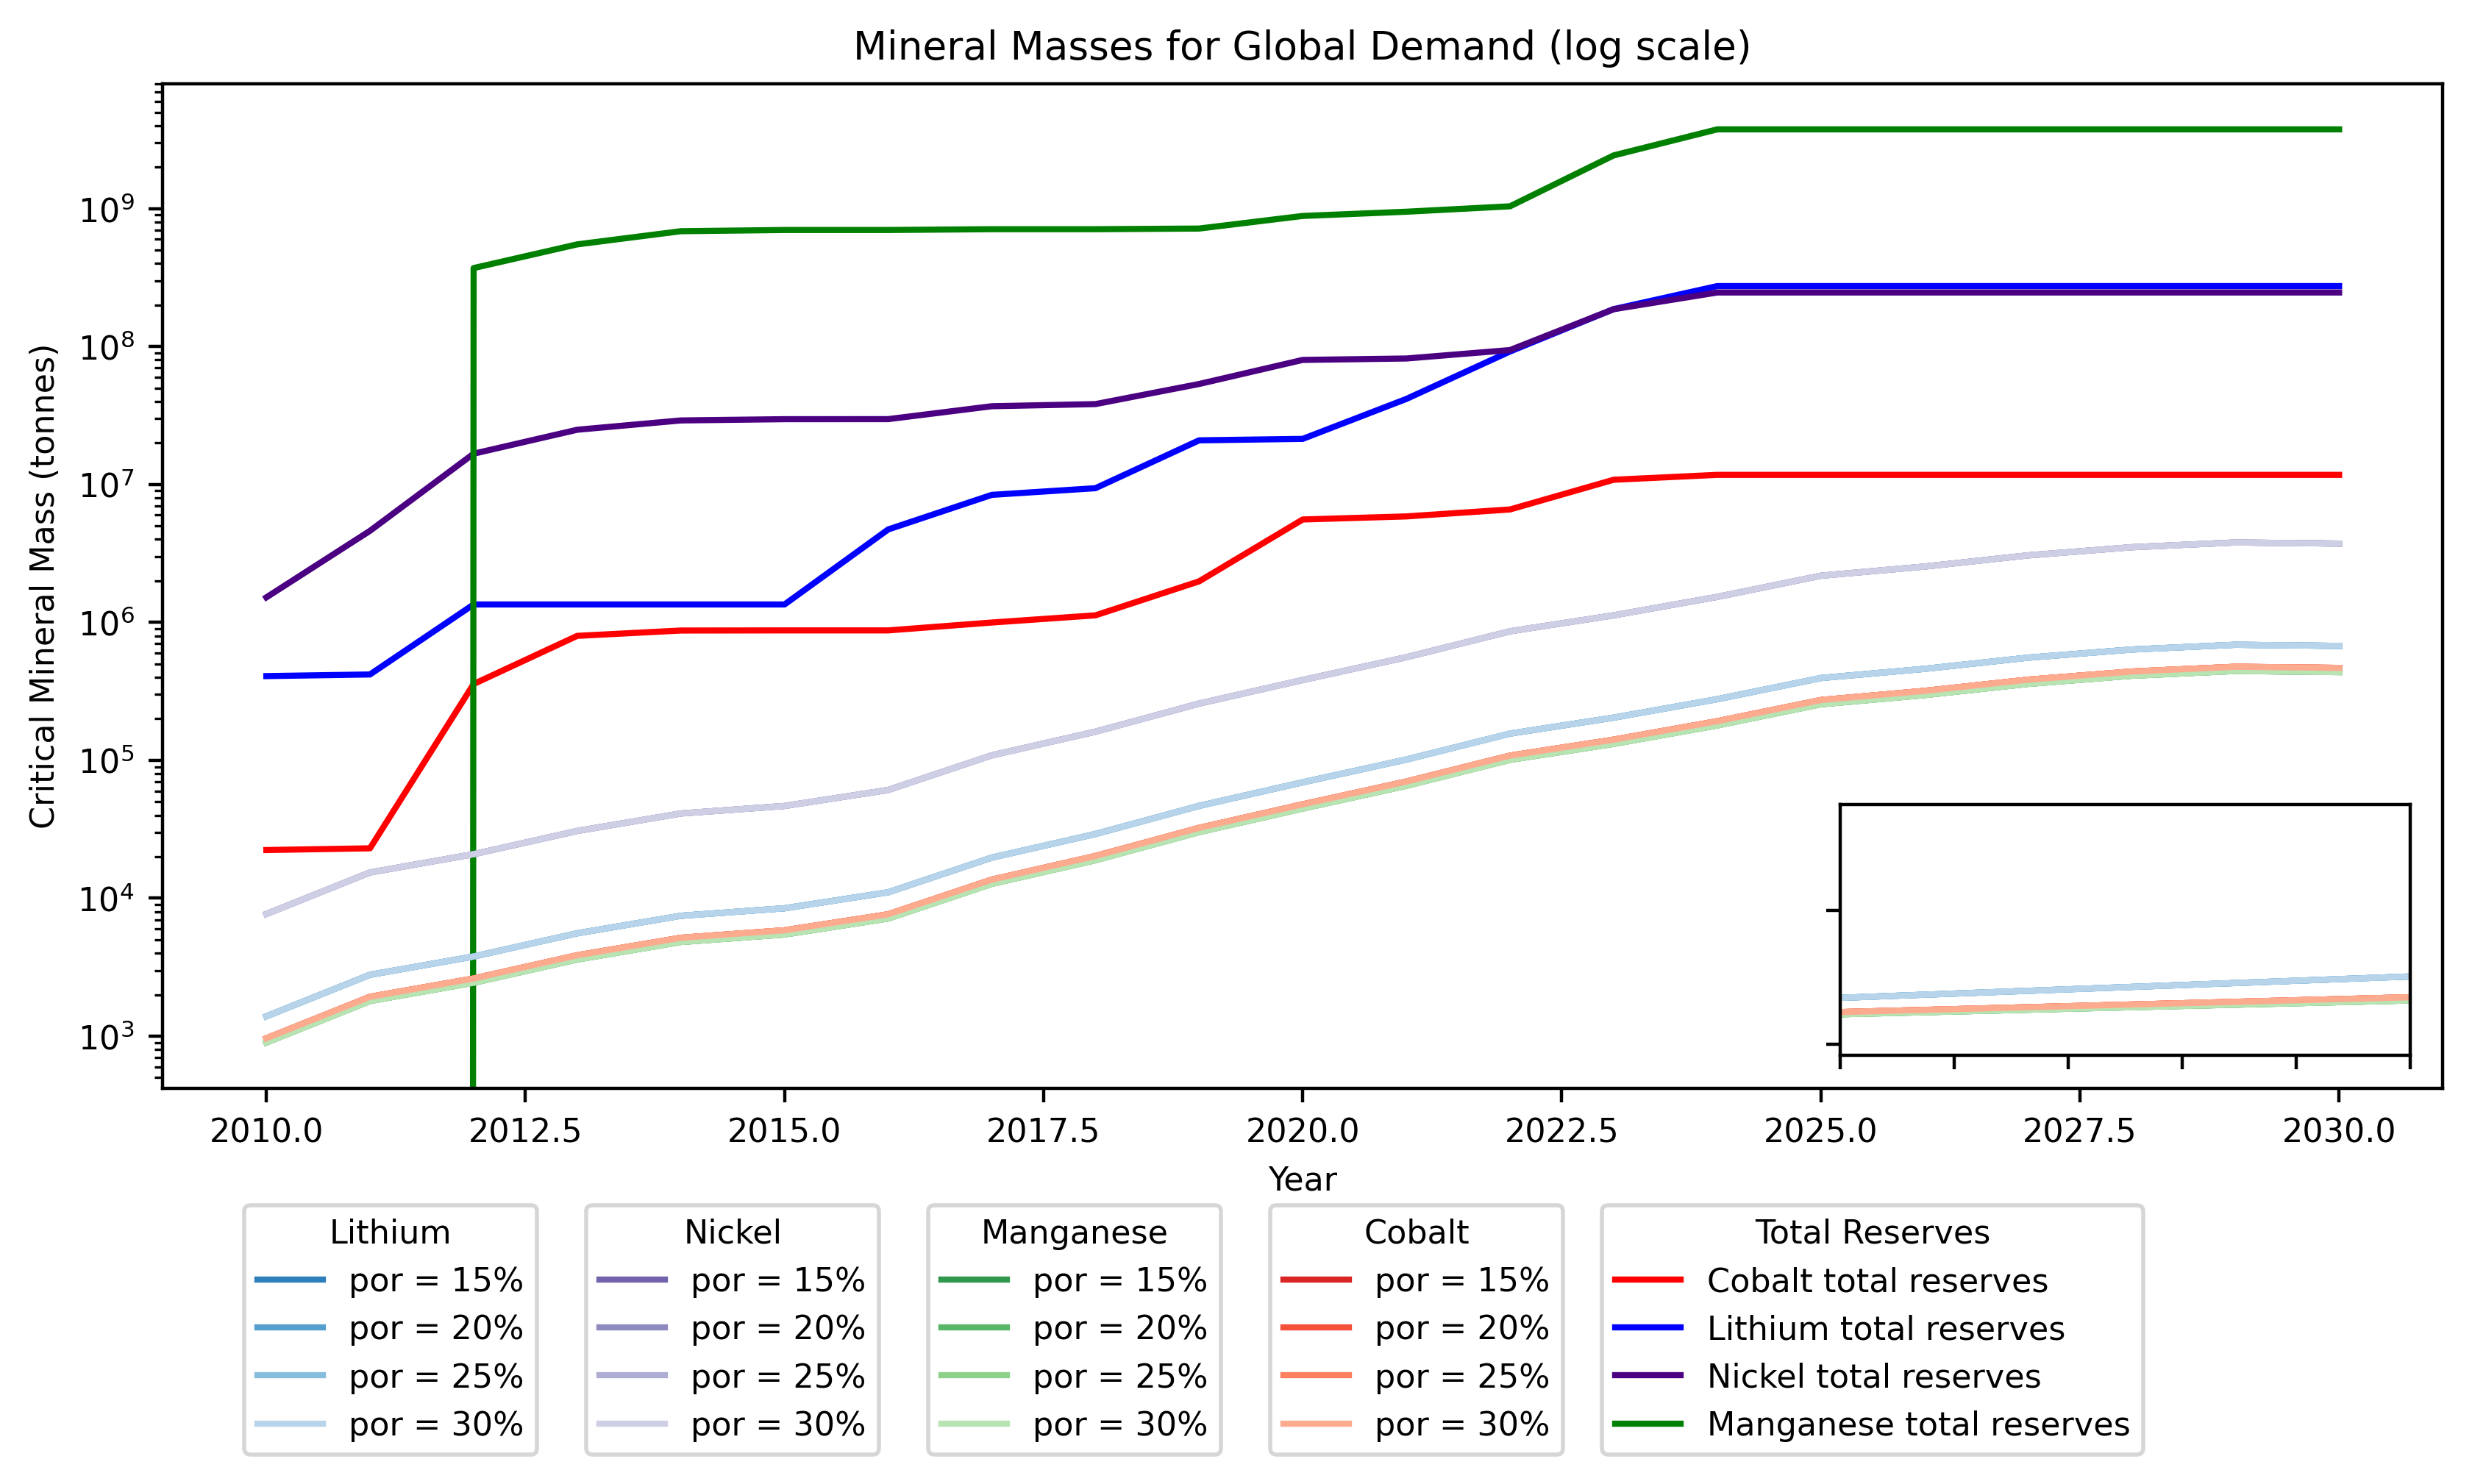

In [33]:
# add inset locator to depict small scale trend 

# section 1: modeling cathodes by porosity, output mass required for demand each year 

model = pybamm.lithium_ion.DFN()

# NMC model
parameter_values_NMC = pybamm.ParameterValues("Chen2020") # NMC parameter set
parameter_values_NMC["Current function [A]"] = 5
parameter_values_NMC["Positive electrode porosity"] = "[input]"

sim = pybamm.Simulation(model, parameter_values=parameter_values_NMC)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_NMC = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_NMC.append(voltage)


# LFP model
parameter_values_LFP = pybamm.ParameterValues("Prada2013") # LFP parameter set 
parameter_values_LFP["Current function [A]"] = 5
parameter_values_LFP["Positive electrode porosity"] = "[input]"

solver = pybamm.CasadiSolver(rtol=1e-4, atol=1e-6) # loosening tolerances to accomidate high current draw and unrealistically low porosities 
sim = pybamm.Simulation(model, parameter_values=parameter_values_LFP)

porosities = [0.15, 0.20, 0.25, 0.30]
av_voltages_LFP = []

for por in porosities:
    soln = sim.solve([0, 3600], inputs={"Positive electrode porosity": por})
    voltage = np.mean(soln["Positive electrode bulk open-circuit potential [V]"].data)  # nominal voltage
    av_voltages_LFP.append(voltage)

# calculating masses
demand_file = '/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Group/Data/Gigafactory and Mining Data/Capacity.xlsx'
df_demand = pd.read_excel(demand_file)

# % energy met by NMC, LFP each year

df_demand['gwh_LFP'] = df_demand["Capacity"] * df_demand["percent LFP"] 
df_demand['gwh_NMC'] = df_demand["Capacity"] * df_demand["percent NMC"] 

Li_cmap = plt.cm.Blues_r
Li_color = Li_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Ni_cmap = plt.cm.Purples_r
Ni_color = Ni_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Mn_cmap = plt.cm.Greens_r
Mn_color = Mn_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Co_cmap = plt.cm.Reds_r
Co_color = Co_cmap(np.linspace(0.3, 0.7, len(av_voltages_NMC)))

Li_lines = []
Li_lines_ins = []
Ni_lines = []
Ni_lines_ins = []
Mn_lines = []
Mn_lines_ins = []
Co_lines = []
Co_lines_ins = []
reserves_lines = []
reserves_lines_extend = []

# making figure with 4 rows and 1 col, filling 3/4ths of the rows with our plot + leaving the last row for legends
fig = plt.figure(figsize=(10, 6), dpi=400)
gs = gridspec.GridSpec(4, 1) # grid of 4 rows, 1 col
ax1 = fig.add_subplot(gs[0:3, :]) # plot in first 3 rows
ax2 = fig.add_subplot(gs[3, :])   
ax2.axis('off')  
ax1.set_yscale("log")

ax3 = inset_axes(ax1, width="25%", height="25%", loc="lower right", borderpad=1)
ax3.tick_params(labelleft=False, labelbottom=False)
#ax3.set_ylim(9000, 11000)
ax3.set_xlim(2020, 2021)
def forward(x):
    return x*0.1
def inverse(x):
    return x*0.9
ax3.set_yscale('function', functions = (forward, inverse)) 

# add total reserves 

extended_reserves = "/Users/isabelagaloustian/Library/CloudStorage/OneDrive-DrexelUniversity/General - Chang Lab/Individual/Isabela Galoustian/EPRI/reserves_extended.xlsx"
df_extended_reserves = pd.read_excel(extended_reserves)

dict = {
    "Cobalt": "red",
    "Lithium": "blue",
    "Nickel": "Indigo",  
    "Manganese": "green"
}

for mineral, color in dict.items():
    mineral_set_real = df_extended_reserves[df_extended_reserves["Primary Mineral"] == mineral].iloc[:63]
    line, = ax1.plot(mineral_set_real["Year"], mineral_set_real["Cumulative Reserves"], color=color, label = f'{mineral} total reserves')
    reserves_lines.append(line)

    mineral_set_extend = df_extended_reserves[df_extended_reserves["Primary Mineral"] == mineral].iloc[64:]
    line, = ax1.plot(mineral_set_extend["Year"], mineral_set_extend["Cumulative Reserves"], color=color, linestyle = 'dashed')
    reserves_lines_extend.append(line)

# plot masses

for c, (v, p) in enumerate(zip(av_voltages_NMC, porosities)):

    Li_mass_por_LFP = [AM_calc(yr, v, "LFP")[0] for yr in df_demand['gwh_LFP']] 
    Li_mass_por_NMC = [AM_calc(yr, v, "NMC811")[0] for yr in df_demand['gwh_NMC']]
    Li_mass_por_tot = [Li_mass_por_LFP[i] + Li_mass_por_NMC[i] for i in range(len(Li_mass_por_LFP))]
    line, = ax1.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    line2, = ax3.plot(df_demand['Year'], Li_mass_por_tot, label = f'por = {p*100:.0f}%', color = Li_color[c])
    Li_lines.append(line)
    Li_lines_ins.append(line2)
    #li_sensitivity = (li_mass_por_tot / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Lithium"]["Cumulative Reserves"]) * 100
    #print(f'Li por {p} sensitivity for 2010-2030: {li_sensitivity}')

    Ni_mass_por = [AM_calc(yr, v, "NMC811")[1] for yr in df_demand['gwh_NMC']] # for porosity 1, mass for all years
    line, = ax1.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    line2, = ax3.plot(df_demand['Year'], Ni_mass_por, label = f'por = {p*100:.0f}%', color = Ni_color[c])
    Ni_lines.append(line)
    Ni_lines_ins.append(line2)
    #ni_sensitivity = (Ni_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Nickel"]["Cumulative Reserves"]) * 100
    #print(f'Ni por {p} sensitivity for 2010-2030: {ni_sensitivity}')

    Mn_mass_por = [AM_calc(yr, v, "NMC811")[2] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    line2, = ax3.plot(df_demand['Year'], Mn_mass_por, label = f'por = {p*100:.0f}%', color = Mn_color[c])
    Mn_lines.append(line)
    Mn_lines_ins.append(line2)
    #mn_sensitivity = (Mn_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Manganese"]["Cumulative Reserves"]) * 100
    #print(f'Mn por {p} sensitivity for 2010-2030: {mn_sensitivity}')
 
    Co_mass_por = [AM_calc(yr, v, "NMC811")[3] for yr in df_demand['gwh_NMC']]
    line, = ax1.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    line2, = ax3.plot(df_demand['Year'], Co_mass_por, label = f'por = {p*100:.0f}%', color = Co_color[c])
    Co_lines.append(line)
    Co_lines_ins.append(line2)
    #co_sensitivity = (Co_mass_por / df_extended_reserves[df_extended_reserves["Primary Mineral"] == "Cobalt"]["Cumulative Reserves"]) * 100
    #print(f'Co por {p} sensitivity for 2010-2030: {Co_sensitivity}')

ax1.set_xlabel('Year')
ax1.set_ylabel('Critical Mineral Mass (tonnes)')
ax1.set_title('Mineral Masses for Global Demand (log scale)')

li_legend = ax1.legend(handles = Li_lines, title = "Lithium", loc = 'upper center', bbox_to_anchor = (0.10, -0.1), ncol = 1)
ax1.add_artist(li_legend)
ni_legend = ax1.legend(handles = Ni_lines, title = "Nickel", loc = 'upper center', bbox_to_anchor = (0.25, -0.1), ncol = 1)
ax1.add_artist(ni_legend)
mn_legend = ax1.legend(handles = Mn_lines, title = "Manganese", loc = 'upper center', bbox_to_anchor = (0.40, -0.1), ncol = 1)
ax1.add_artist(mn_legend)
co_legend = ax1.legend(handles = Co_lines, title = "Cobalt", loc = 'upper center', bbox_to_anchor = (0.55, -0.1), ncol = 1)
ax1.add_artist(co_legend)
reserves_legend = ax1.legend(handles=reserves_lines, title = "Total Reserves", loc = 'upper center', bbox_to_anchor = (0.75, -0.1), ncol = 1)

